In [88]:
%matplotlib auto

Using matplotlib backend: nbAgg


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import cos, sin, pi, sqrt, real, imag, matmul
from scipy.fft import fft, fftfreq

In [2]:
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 1.5, "ytick.major.size": 1.5, 
                        "xtick.direction": "in","ytick.direction": "in"})
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend',fontsize=8)
cmap = sns.color_palette(n_colors=10)


In [3]:
I = np.identity(2)
sigm_z = np.array([[1., 0.], [0., -1.]])
sigm_y = np.array([[0., -1j], [1j, 0.]])
sigm_x = np.array([[0., 1.], [1., 0.]])
sigm = np.array([sigm_x, sigm_y, sigm_z])

def Uop(angvec): # Build the unitary operator from the roatation angle and vector
    ang, n = angvec[0], angvec[1:]
    U = cos(ang)*I-1j*sin(ang)*(n[0]*sigm_x +n[1]*sigm_y +n[2]*sigm_z)
    return U

def AngVec(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(0.5*np.trace(U))
    nx = 0.5j*np.trace(matmul(U, sigm_x))/sin(ang)
    ny = 0.5j*np.trace(matmul(U, sigm_y))/sin(ang)
    nz = 0.5j*np.trace(matmul(U, sigm_z))/sin(ang)
    n = real([nx, ny, nz])
    n = real( n/np.sqrt(np.sum(n*n,axis=0)))
    return np.array([real(ang), n[0], n[1], n[2]])
    
def mulAng(op2, op1): # angle of multiplied operator
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    dot = np.sum(n1*n2, axis=0)/np.sum(n1*n1, axis=0)/np.sum(n2*n2, axis=0)
    return np.arccos(cos(ang1)*cos(ang2)-dot*sin(ang1)*sin(ang2))

def mulVec(op2, op1):
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    ang = mulAng(op2, op1)
    cross21 = np.array([n2[1]*n1[2]-n2[2]*n1[1], n2[2]*n1[0]-n2[0]*n1[2], n2[0]*n1[1]-n2[1]*n1[0]])
    n = sin(ang1)*cos(ang2)*n1+sin(ang2)*cos(ang1)*n2-sin(ang1)*sin(ang2)*cross21
    n = n/sin(ang)
    return np.array([ang, n[0],n[1],n[2]])
    
#################################### This is true only for spin1/2 but it is faster!###################
def Uop2(angvec): # Build the unitary operator from the roatation angle and vector
    ang, [nx, ny, nz] = angvec
    U = np.array([[cos(ang)-1j*nz*sin(ang), -1j*nx*sin(ang)-ny*sin(ang)],
                 [-1j*nx*sin(ang)+ny*sin(ang), cos(ang)+1j*nz*sin(ang)]])
    return U

def AngVec2(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(real(U[0,0]))
    nx = -imag(U[0,1])/sin(ang)
    ny = -real(U[0,1])/sin(ang)
    nz = -imag(U[0,0])/sin(ang)
    n = real(np.array([nx, ny, nz]))
    return [real(ang), n/np.linalg.norm(n)]
############################################################################################################

In [4]:
def Hahn_echo(fL, Azz, Azx, tau, s1=1, s0=0): #Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    ang_V0 = np.arccos(cos(Ome0*tau/2)*cos(Ome1*tau/2)-dot *sin(Ome0*tau/2)*sin(Ome1*tau/2))
    n_V0 = np.array([cos(Ome1*tau/2)*sin(Ome0*tau/2)*mx +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nx,
                     -sin(Ome1*tau/2)*sin(Ome0*tau/2)*q,
                    cos(Ome1*tau/2)*sin(Ome0*tau/2)*mz +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nz])
    n_V0 = n_V0/np.sqrt(np.sum(n_V0*n_V0, axis=0))
    
    
    V0 = np.array([ang_V0, n_V0[0], n_V0[1], n_V0[2]])
    V1d = np.array([ang_V0, -n_V0[0], n_V0[1], -n_V0[2]]) 
    sigma_z = cos(mulAng(V0, V1d))
    return -np.prod(sigma_z)
def anal_HE_general(fL, Azz, Azx, tau, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2
    return -np.prod(sigma_z)
def Generate_noisy_signal(p, N_meas): # p=1 bright state, p=0 dark state probability
    projection = np.random.binomial(np.ones_like(p,dtype=int),p, size=(N_meas,p.shape[0]))
    average_proj = np.sum(projection, axis=0)
    emit_bright, emit_dark = 3, 0.1 # every measurement how many photons is detected on average
    n_bright = np.random.poisson(average_proj*emit_bright)
    n_dark = np.random.poisson((N_meas-average_proj)*emit_dark)
    n_total = n_bright+n_dark
    return n_total/(N_meas*emit_bright) # noisy probability of bright state


In [5]:
def DD(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

def anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-one_minus_dot*sin(N_pi/2*Thet)**2
#     sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)

def anal_DDold(fL, Azz, Azx, tau, N_pi, ms=1): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    Ome_L = 2*pi*fL
    Azz, Azx = 2*pi*ms*Azz, 2*pi*ms*Azx
    Ome_h = np.sqrt((Ome_L+Azz)**2+Azx**2) #
    
    Thet= np.arccos(cos(Ome_L*tau)*cos(Ome_h*tau)-((Ome_L+Azz)/Ome_h)*sin(Ome_L*tau)*sin(Ome_h*tau))
    sigma_z = 1-(Azx/Ome_h)**2*(1-cos(Ome_L*tau))*(1-cos(Ome_h*tau))*sin(N_pi/2*Thet)**2/(1+cos(Thet))  
    return -np.prod(sigma_z)

def just_angle_V0V1(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    theta = np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
#     return theta/2
    return 1- q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*(sin(N*theta/2)**2)/(cos(theta/2)**2)
#     return q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(theta))

In [6]:
def anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome_a = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome_b = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome_a, (OmeL+s0*Azz)/Ome_a
    nx, nz = s1*Azx/Ome_b, (OmeL+s1*Azz)/Ome_b
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome_a/Ome_b
    q = (s1-s0)*OmeL*Azx/Ome_a/Ome_b
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome_a/Ome_b
    

    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(s0*Azx, OmeL+s0*Azz)     ## specific for spin 1/2
    Eta_b = np.arctan2(s1*Azx, OmeL+s1*Azz)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    signal = 0.25*(np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4))
    return signal

def ddeseem(fL, Azz, Azx, tau1, tau2, tc, N, s1=1, s0=-1): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome0/Ome1
    
    tau = tau1
    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    tau=tau2
    ang_WD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_WD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_WD0 /=np.sqrt(np.sum(n_WD0*n_WD0,axis=0))
    
    n_WD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_WD1 /=np.sqrt(np.sum(n_WD1*n_WD1,axis=0))
    
    
    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    WD0 = np.array([ang_WD0, n_WD0[0], n_WD0[1], n_WD0[2]])
    WD0d = np.array([ang_WD0, -n_WD0[0], -n_WD0[1], -n_WD0[2]])
    WD1 = np.array([ang_WD0, n_WD1[0], n_WD1[1], n_WD1[2]])
    WD1d = np.array([ang_WD0, -n_WD1[0], -n_WD1[1], -n_WD1[2]])
    
    VD0VD1d= mulVec(VD0, VD1d)
    WD0F0 = mulVec(WD0, F0)
    WD0F1 = mulVec(WD0, F1)
    WD1F0 = mulVec(WD1, F0)
    WD1F1 = mulVec(WD1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]]))))

#     F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
#     F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
#     F0dWD1d = mulVec(F0d, WD1d)
#     F0dWD0d = mulVec(F0d, WD0d)
#     F1dWD1d = mulVec(F1d, WD1d)
#     F1dWD0d = mulVec(F1d, WD0d)
    
#     W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), F0dWD1d)))
#     W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), F0dWD0d)))
#     W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), F1dWD1d)))
#     W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), F1dWD0d)))
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)


In [5]:
r = np.arange(0.1,5,0.2) # in nm
V = 4/3*np.pi*r**3 # in nm**3
Va = 0.0056818 # in nm**3
n = V/Va*0.01
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(r, n, 'o')
plt.axline((4.2, 0), (4.2, 800), linewidth=2, linestyle='--', color='r', label='T1 limit')
plt.xlabel('Radius (nm)')
plt.ylabel('Number of Nuclear Spins')
plt.legend()
mu0 = 1.2566e-6
gamma_e, gamma_C = 28.025e9, 10.708e6
hbar = 1.0545e-34
coupling = mu0* gamma_e* gamma_C*hbar/4/np.pi/(1e-9)**3
coupling

3164.373648288011

# Let's define the nuclear spin register couplings (C1 to C23)

In [9]:
# determining the parameters
fL = 403.4983*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([-20.72, -23.22, -31.25, -14.07, -11.346, -48.58, -8.32, -9.79, 213.154, 17.643, 14.548, 20.569, 8.029,
               -19.815, -13.961, -4.66, -5.62, -36.308, 24.399, 2.69, 1.212, 7.683, -3.177]) # kHz
Azx = np.array([12, 13, 8, 13, 59.21, 9, 3, 5, 3, 8.6, 10, 41.51, 21, 5.3, 9, 7, 5, 26.62, 24.81, 11, 13, 4, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=431.94493014999995 kHz
Azz=[-20.72  -23.22  -31.25  -14.07  -11.346 -48.58   -8.32   -9.79  213.154
  17.643  14.548  20.569   8.029 -19.815 -13.961  -4.66   -5.62  -36.308
  24.399   2.69    1.212   7.683  -3.177] kHz
Azx=[12.   13.    8.   13.   59.21  9.    3.    5.    3.    8.6  10.   41.51
 21.    5.3   9.    7.    5.   26.62 24.81 11.   13.    4.    2.  ] kHz
Freq hyp up=[411.39997955 408.9316184  400.77478345 418.07709486 424.74614082
 383.47055906 423.63555262 422.18453909 645.10590579 449.67017573
 446.60489997 454.41383901 440.4748111  412.1640078  418.0808126
 427.34226509 426.3542495  396.53146773 457.01785379 434.77410515
 433.35196565 439.64612698 428.77259465] kHz
Blind Spot up=[2.43072448 2.44539663 2.49516696 2.39190334 2.35434747 2.60776213
 2.36051954 2.36863245 1.55013307 2.22385218 2.2391156  2.2006372
 2.27027738 2.42621864 2.39188207 2.34004469 2.34546742 2.52186795
 2.18809832 2.30004498 2.30759309 2.2745566  2.33223861] us
Freq hyp dn=[452.82396026 

# Hahn Echo

100%|██████████| 2000/2000 [00:00<00:00, 5727.33it/s]


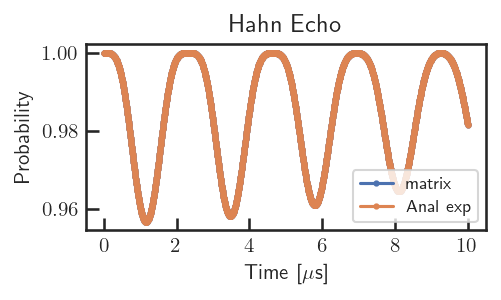

In [10]:
start = 10e-6 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_meas = int(1e4)

Signal = []
Signal_anal = []
for tau in tqdm(Taus):
    sigma_z = Hahn_echo(fL, Azz, Azx, tau)
    Signal.append(sigma_z)
    sigma_z = anal_HE_general(fL, Azz, Azx, tau)
    Signal_anal.append(sigma_z)
Signal = np.array(Signal)
Signal_anal = np.array(Signal_anal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p, '-o',markersize=2, alpha = 1, label='matrix')
plt.plot(Taus*1000, p_anal, '-o',markersize=2, alpha = 1, label='Anal exp')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('Hahn Echo')
plt.legend()
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')

# Dynamical Decoupling

In [11]:
def DD(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

def anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-one_minus_dot*sin(N_pi/2*Thet)**2
#     sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)

def anal_DDold(fL, Azz, Azx, tau, N_pi, ms=1): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    Ome_L = 2*pi*fL
    Azz, Azx = 2*pi*ms*Azz, 2*pi*ms*Azx
    Ome_h = np.sqrt((Ome_L+Azz)**2+Azx**2) #
    
    Thet= np.arccos(cos(Ome_L*tau)*cos(Ome_h*tau)-((Ome_L+Azz)/Ome_h)*sin(Ome_L*tau)*sin(Ome_h*tau))
    sigma_z = 1-(Azx/Ome_h)**2*(1-cos(Ome_L*tau))*(1-cos(Ome_h*tau))*sin(N_pi/2*Thet)**2/(1+cos(Thet))  
    return -np.prod(sigma_z)

def just_angle_V0V1(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    theta = np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
#     return theta/2
    return 1- q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*(sin(N*theta/2)**2)/(cos(theta/2)**2)
#     return q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(theta))

100%|███████████████████████████████████| 1200/1200 [00:00<00:00, 10920.20it/s]


<IPython.core.display.Javascript object>


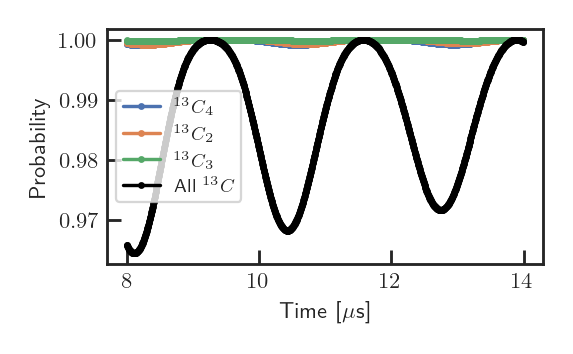

In [45]:
start = 8e-3 # in ms
duration = 6e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

Ang_0 = []
Ang_1 = []
Ang_2 = []
All = []
for tau in tqdm(Taus):
    sigma_z = anal_HE_general(fL, Azz[3], Azx[3], tau, s1=1, s0=0)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_HE_general(fL, Azz[1], Azx[1], tau, s1=1, s0=0)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_HE_general(fL, Azz[2], Azx[2], tau, s1=1, s0=0)
    Ang_2.append(0.5-0.5*sigma_z)
    sigma_z = anal_HE_general(fL, Azz, Azx, tau, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, Ang_0, '-o',markersize=2, label=r'$^{13}C_4$')
plt.plot(Taus*1000, Ang_1, '-o',markersize=2, label=r'$^{13}C_2$')
plt.plot(Taus*1000, Ang_2, '-o',markersize=2, label=r'$^{13}C_3$')
plt.plot(Taus*1000, All, '-o',markersize=2, color='black', label='All $^{13}C$')
# for p in range(0, 100):
#     t_reson = (2*p+1)/(4*fL+2*Azz[3])
#     if t_reson< Taus[-1] and t_reson> Taus[0]: plt.axvline(t_reson*1000, color='C0')
#     t_reson = (2*p+1)/(4*fL+2*Azz[1])
#     if t_reson< Taus[-1] and t_reson> Taus[0]: plt.axvline(t_reson*1000, color='C1')
#     t_reson = (2*p+1)/(4*fL+2*Azz[2])
#     if t_reson< Taus[-1] and t_reson> Taus[0]: plt.axvline(t_reson*1000, color='C2')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()
# plt.savefig('HE_3.png', dpi=150)
# plt.savefig('HE_all.png', dpi=150)

100%|████████████████████████████████████| 1667/1667 [00:00<00:00, 9697.46it/s]


<IPython.core.display.Javascript object>


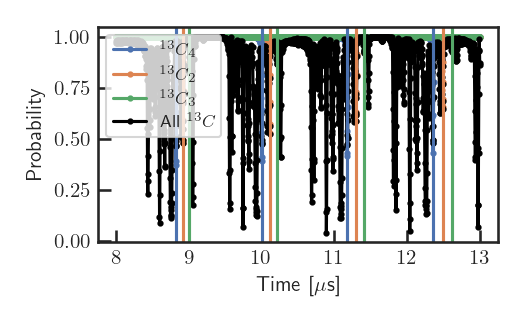

In [42]:
start = 8e-3 # in ms
duration = 5e-3 # in ms
incre = 3e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

Ang_0 = []
Ang_1 = []
Ang_2 = []
All = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz[3], Azx[3], tau, N_pi, s1=1, s0=0)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, Azz[1], Azx[1], tau, N_pi, s1=1, s0=0)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, Azz[2], Azx[2], tau, N_pi, s1=1, s0=0)
    Ang_2.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, Ang_0, '-o',markersize=2, label=r'$^{13}C_4$')
plt.plot(Taus*1000, Ang_1, '-o',markersize=2, label=r'$^{13}C_2$')
plt.plot(Taus*1000, Ang_2, '-o',markersize=2, label=r'$^{13}C_3$')
plt.plot(Taus*1000, All, '-o',markersize=2, color='black', label='All $^{13}C$')
for p in range(0, 100):
    t_reson = (2*p+1)/(4*fL+2*Azz[3])
    if t_reson< Taus[-1] and t_reson> Taus[0]: plt.axvline(t_reson*1000, color='C0')
    t_reson = (2*p+1)/(4*fL+2*Azz[1])
    if t_reson< Taus[-1] and t_reson> Taus[0]: plt.axvline(t_reson*1000, color='C1')
    t_reson = (2*p+1)/(4*fL+2*Azz[2])
    if t_reson< Taus[-1] and t_reson> Taus[0]: plt.axvline(t_reson*1000, color='C2')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.legend(loc=2)
plt.tight_layout()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
# plt.savefig('DD_all_64pulse_zoom.png',dpi=150)

In [71]:
## only two close nuclei spin 1

######################################################

######################################################
start = 12e-3 # in ms
duration = 1e-3 # in ms
incre = 3e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 8 # number of pi pulses
N_meas = int(1e4)

Ang_0 = []
Ang_1 = []
All = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz[3], Azx[3], tau, N_pi, s1=1, s0=0)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, Azz[1], Azx[1], tau, N_pi, s1=1, s0=0)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, Azz[1:4:2], Azx[1:4:2], tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.vlines(12.370, ymin=min(All), ymax=1, color='C0', linestyles ='dashed')
plt.vlines(12.509, ymin=min(All), ymax=1, color='C1', linestyles ='dashed')

plt.plot(Taus*1000, Ang_0, label=r'$^{13}C_1$')
plt.plot(Taus*1000, Ang_1, label=r'$^{13}C_2$')
plt.plot(Taus*1000, All, color='black', label='Both')
# plt.xlabel(r"$\tau$")
plt.ylabel('Counts')
# plt.legend(loc=5)
plt.tight_layout()
# res_C1 = 1/(4*fL+2*Azz[3]) # in ms
# res_C2 = 1/(4*fL+2*Azz[1]) # in ms
# Res_C1 = np.array([res_C1*odd for odd in range(1000) if odd%2==1 and res_C1*odd>min(Taus) and res_C1*odd<max(Taus)]) # bath resonance in ms
# Res_C2 = np.array([res_C2*odd for odd in range(1000) if odd%2==1 and res_C2*odd>min(Taus) and res_C2*odd<max(Taus)])
# plt.vlines(Res_C1*1000, ymin=min(All), ymax=1, color='C0', linestyles ='dashed')
# plt.vlines(Res_C2*1000, ymin=min(All), ymax=1, color='C1', linestyles ='dashed')

plt.xticks([12.370, 12.509], [r'$\tau_r^{(1)}$', r'$\tau_r^{(2)}$'])
plt.yticks([])


fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.000051,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_DD.svg',dpi=150)

100%|██████████████████████████████████████| 334/334 [00:00<00:00, 9595.58it/s]


<IPython.core.display.Javascript object>

In [31]:
## only two close nuclei spin 1 high coupling

######################################################

######################################################
start =0.1e-3 # in ms
duration = 11e-3 # in ms
incre = 3e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 8 # number of pi pulses
N_meas = int(1e4)
fL = 40.34983*1.0705 # kHz
Ang_0 = []
Ang_1 = []
All = []
Apzz = np.concatenate((np.array([20*Azz[1], 20*Azz[3]]), Azz[4:]))
Apzx = np.concatenate((np.array([20*Azx[1], 20*Azx[3]]), Azx[4:]))
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, 20*Azz[3], 20*Azx[3], tau, N_pi, s1=1, s0=0)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, 20*Azz[1], 20*Azx[1], tau, N_pi, s1=1, s0=0)
    Ang_1.append(0.5-0.5*sigma_z)
#     sigma_z = anal_DD_general(fL, np.array([10*Azz[3], 10*Azz[1]]), np.array([10*Azx[3], 10*Azx[1]]),
#                               tau, N_pi, s1=1, s0=0)
    sigma_z = anal_DD_general(fL, Apzz, Apzx,
                              tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.plot(Taus*1000, Ang_0, label=r'$^{13}C_1$')
plt.plot(Taus*1000, Ang_1, label=r'$^{13}C_2$')
plt.plot(Taus*1000, All, alpha=0.8, color='black', label='Both')
plt.xlabel(r"$\tau$")
plt.ylabel('Counts')
# plt.legend(loc=5)
plt.tight_layout()
plt.xticks([])
plt.yticks([])

res_C1 = 1/(4*fL+10*Azz[3]) # in ms
res_C2 = 1/(4*fL+10*Azz[1]) # in ms
Res_C1 = np.array([res_C1*odd for odd in range(1000) if odd%2==1 and res_C1*odd>min(Taus) and res_C1*odd<max(Taus)]) # bath resonance in ms
Res_C2 = np.array([res_C2*odd for odd in range(1000) if odd%2==1 and res_C2*odd>min(Taus) and res_C2*odd<max(Taus)])
# plt.vlines(Res_C1*1000, ymin=min(All), ymax=1, color='C0', linestyles ='dashed')
# plt.vlines(Res_C2*1000, ymin=min(All), ymax=1, color='C1', linestyles ='dashed')

fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.000051,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_DD_high_A.svg',dpi=150)
fL = 403.4983*1.0705 # kHz

100%|███████████████████████████████████| 3667/3667 [00:00<00:00, 13043.28it/s]


<IPython.core.display.Javascript object>

In [70]:
## only two close nuclei spin 1/2

######################################################

######################################################
start = 11.8e-3 # in ms
duration = 1e-3 # in ms
incre = 3e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 8 # number of pi pulses
N_meas = int(1e4)

Ang_0 = []
Ang_1 = []
All = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz[3], Azx[3], tau, N_pi, s1=0.5, s0=-0.5)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, Azz[1], Azx[1], tau, N_pi, s1=0.5, s0=-0.5)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL, Azz[1:4:2], Azx[1:4:2], tau, N_pi, s1=0.5, s0=-0.5)
    All.append(0.5-0.5*sigma_z)

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.vlines(12.169, ymin=min(All), ymax=1, color='C0', linestyles ='dashed')
plt.vlines(12.180, ymin=min(All), ymax=1, color='C1', linestyles ='dashed')


plt.plot(Taus*1000, Ang_0, label=r'$^{13}C_1$')
plt.plot(Taus*1000, Ang_1, label=r'$^{13}C_2$')
plt.plot(Taus*1000, All, color='black', label='Both')
# plt.xlabel(r"$\tau$")
plt.ylabel('Counts')
# plt.legend(loc=5)
plt.tight_layout()
plt.xticks([12.175], [r'$\tau_r^{(1)}, \, \tau_r^{(2)}$'])
plt.yticks([])



fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.000051,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_DD_half.svg',dpi=150)

100%|█████████████████████████████████████| 334/334 [00:00<00:00, 11570.02it/s]


<IPython.core.display.Javascript object>

In [63]:
## only two close nuclei spin 1 dual species

######################################################

######################################################
start = 3.2e-3 # in ms
duration =5e-3 # in ms
incre = 3e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 8 # number of pi pulses
N_meas = int(1e4)
fL1 = 403.4983*1.0705 # kHz Carbon
fL2 = 403.4983*(-0.8465) # kHz Silicon
# fL2 = fL1
Ang_0 = []
Ang_1 = []
All = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL1, 0, 100, tau, N_pi, s1=1, s0=0)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(fL2, 0, 100, tau, N_pi, s1=1, s0=0)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_DD_general(np.array([fL1, fL2]), np.array([0,0]), np.array([100, 100]), tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.plot(Taus*1000, Ang_0, label=r'$^{13}C$')
plt.plot(Taus*1000, Ang_1, label=r'$^{28}Si$')
plt.plot(Taus*1000, All, alpha=0.5, color='black', label='Both')

bath_C = 1/(4*fL1) # in ms
bath_Si = abs(1/(4*fL2)) # in ms, is physical to use absolute value?
tau_bath_C = np.array([bath_C *odd for odd in range(1000) if odd%2==1 and bath_C*odd>min(Taus) and bath_C*odd<max(Taus)]) # bath resonance in ms
tau_bath_Si = np.array([bath_Si*odd for odd in range(1000) if odd%2==1 and bath_Si*odd>min(Taus) and bath_Si*odd<max(Taus)])
# plt.vlines(tau_bath_C*1000, ymin=min(All), ymax=1, color='C0', linestyles ='dashed')
# plt.vlines(tau_bath_Si*1000, ymin=min(All), ymax=1, color='C1', linestyles ='dashed')

plt.xlabel(r"$\tau$")
plt.ylabel('Counts')
# plt.legend(loc=5)
plt.tight_layout()
plt.xticks([])
plt.yticks([])


fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.000051,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_DD_dual.svg',dpi=150)

100%|███████████████████████████████████| 1667/1667 [00:00<00:00, 13634.65it/s]


<IPython.core.display.Javascript object>

In [12]:
# Generating colors
import colorsys
def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors
Cols = _get_colors(25)

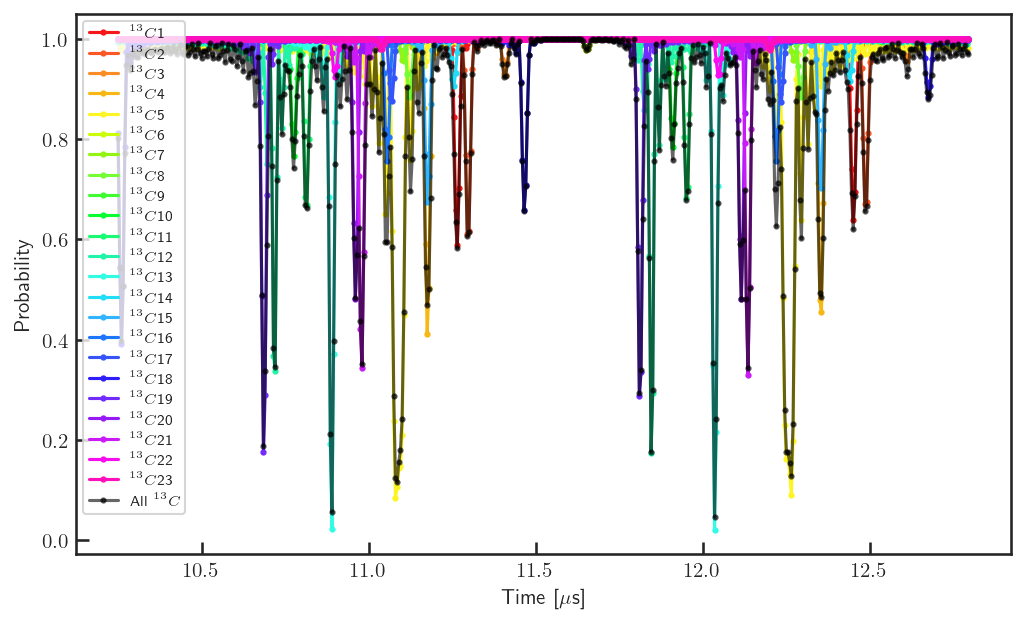

In [13]:
start = 10.25e-3 # in ms
end = 12.8e-3
duration = end-start # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)


plt.figure(dpi=150, figsize=(7,7/1.61803398875))
All = []

for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=1, s0=0)
        Ang_0.append(0.5-0.5*sigma_z)
    plt.plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)
    
plt.plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')

plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.legend(fontsize=7,loc=2)
plt.tight_layout()
# plt.savefig('DD_all_64pulse_color.png',dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
 

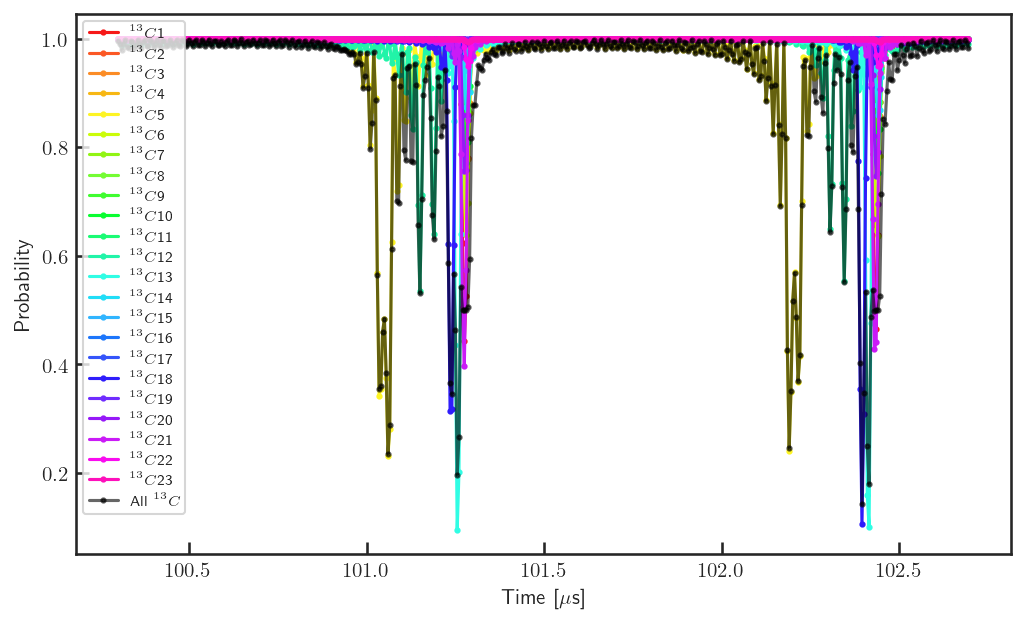

In [14]:
start = 100.3e-3 # in ms
duration = 2.4e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)


plt.figure(dpi=150, figsize=(7,7/1.61803398875))
All = []

for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=0.5, s0=-0.5)
        Ang_0.append(0.5-0.5*sigma_z)
    plt.plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    All.append(0.5-0.5*sigma_z)
    
plt.plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')

plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.legend(fontsize=7,loc=2)
plt.tight_layout()
# plt.savefig('DD_all_64pulse_color_half.png',dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)

# Fisher simulation for DD spin one
parameters for plot 2 of the paper: For both DD in spin 1 and 1/2
start = 1e-3 # in ms
end = 100e-3 # in ms
steps = 1500
Taus = np.linspace(start,end, steps) # in ms
N_pi = 254 # number of pi pulses
s1, s0 = 1, 0
eps=0.01

In [190]:
start = 1e-3 # in ms
end = 100e-3 # in ms
steps = 1500
Taus = np.linspace(start,end, steps) # in ms
N_pi = 16 # number of pi pulses
s1, s0 = 1, 0
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_tau = np.zeros([len(A),len(A)])
Fisher_dd_one = np.zeros([len(A),len(A)])

for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=s1, s0=s0)
    p = 0.5-0.5*sigma_z
    for i in range(len(A)):
        Azzp = Azz.copy()
        Azxp = Azx.copy()
        if i<23: Azzp[i] = Azz[i]+eps
        else:    Azxp[i-23] = Azx[i-23]+eps
        Di=(anal_DD_general(fL,Azzp,Azxp,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1, s0=s0))/eps
        
        for j in range(len(A)):
            Azzq = Azz.copy()
            Azxq = Azx.copy()
            if j<23: Azzq[j] = Azz[j]+eps
            else:    Azxq[j-23] = Azx[j-23]+eps
            Dj=(anal_DD_general(fL,Azzq,Azxq,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1,s0=s0))/eps
            Fisher_tau[i][j] = np.abs(1/(p *(1-p)) * Di* Dj)
    Fisher_dd_one += Fisher_tau

print(np.min(Fisher_dd_one), np.max(Fisher_dd_one))

100%|██████████| 1500/1500 [07:22<00:00,  3.39it/s]

0.00010880394261086844 646.8528986891126


In [131]:
F_A = np.sum(np.diag(Fisher_dd_one))/len(np.diag(Fisher_dd_one))
delta_A = np.sqrt(1/F_A/4000)
delta_A

0.003214929972298437

Text(0.5, 1.0, 'DD for spin 1')

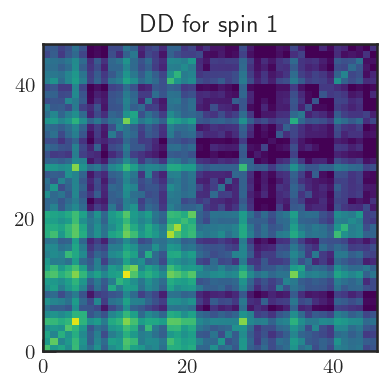

In [191]:
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(Fisher_dd_one), np.max(Fisher_dd_one))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-3,vmax=1e3)
im = plt.pcolormesh(Fisher_dd_one, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher_dd_one.svg',dpi=150)
plt.title('DD for spin 1')


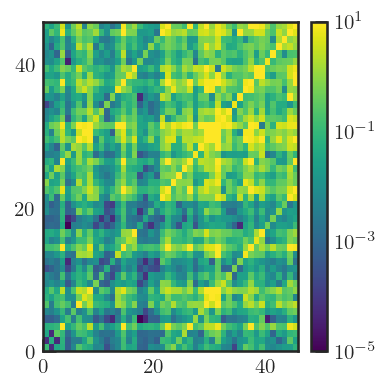

In [192]:
Inv_Fisher_dd_one = np.linalg.inv(Fisher_dd_one)
cov_dd_one = Inv_Fisher_dd_one #*1/steps
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(np.abs(cov_dd_one)), np.max(np.abs(cov_dd_one)))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-5,vmax=1e1)
im = plt.pcolormesh(np.abs(cov_dd_one), norm=norm, cmap='viridis', rasterized=True)
cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
np.min(np.abs(cov_dd_one)), np.max(np.abs(cov_dd_one))
plt.show()

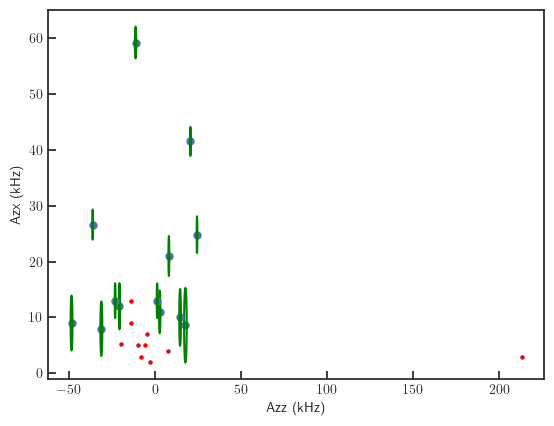

In [193]:
t = np.linspace(0, 2*np.pi, 100)
plt.figure()
plt.plot(Azz, Azx, 'o', markersize=2)
for i in range(len(Azz)):
    X = Azz[i]     #x-position of the center
    Y = Azx[i]    #y-position of the center
    Rx = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
    Ry = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
    if Rx<abs(X)**1 and Ry<abs(Y)**1:
        plt.plot(X, Y, 'o', markersize=5, color='C0')
        plt.plot( X+Rx*np.cos(t) , Y+Ry*np.sin(t) , color = 'green')
        
        x1 = Azz[i]     #x-position of the center
        y1 = Azx[i]    #y-position of the center
        Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
        Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
        for j in range(len(Azz)):
            if j<i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_dd_one[i,j]))
                if c>np.max([Rx1, Rx2]):
                    U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    plt.plot(U,V, color='orange')
                d = np.sqrt(np.abs(cov_dd_one[i+23,j+23]))
                if d>np.max([Ry1, Ry2]):
                    U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    plt.plot(U,V, color='pink')
    else:
        plt.plot(X, Y, 'o', markersize=2, color='red')
###########################################################################3 covariance analysis   
# for i in range(len(Azz)):
#     x1 = Azz[i]     #x-position of the center
#     y1 = Azx[i]    #y-position of the center
#     Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
#     Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
#     for j in range(len(Azz)):
#         if j<i:
#             x2 = Azz[j]     #x-position of the center
#             y2 = Azx[j]    #y-position of the center
#             Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
#             Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
#             c = np.sqrt(np.abs(cov_dd_one[i,j]))
#             if c>np.max([Rx1, Rx2]):
#                 U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
#                 V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
#                 plt.plot(U,V, color='orange')
# for i in range(len(Azz)):
#     x1 = Azz[i]     #x-position of the center
#     y1 = Azx[i]    #y-position of the center
#     Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
#     Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
#     for j in range(len(Azz)):
#         if j<i:
#             x2 = Azz[j]     #x-position of the center
#             y2 = Azx[j]    #y-position of the center
#             Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
#             Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
#             c = np.sqrt(np.abs(cov_dd_one[i+23,j+23]))
#             if c>np.min([Ry1, Ry2]):
#                 U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
#                 V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
#                 plt.plot(U,V, color='pink')
plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
# plt.xlim([-50,50])
plt.show()

# Fisher simulation for DD spin one half

In [170]:
start = 1e-3 # in ms
end = 100e-3 # in ms
steps = 1000
Taus = np.linspace(start,end, steps) # in ms
N_pi = 16 # number of pi pulses
s1, s0 = 0.5, -0.5
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_tau = np.zeros([len(A),len(A)])
Fisher_dd_half = np.zeros([len(A),len(A)])

for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=s1, s0=s0)
    p = 0.5-0.5*sigma_z
    for i in range(len(A)):
        Azzp = Azz.copy()
        Azxp = Azx.copy()
        if i<23: Azzp[i] = Azz[i]+eps
        else:    Azxp[i-23] = Azx[i-23]+eps
        Di=(anal_DD_general(fL,Azzp,Azxp,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1, s0=s0))/eps
        
        for j in range(len(A)):
            Azzq = Azz.copy()
            Azxq = Azx.copy()
            if j<23: Azzq[j] = Azz[j]+eps
            else:    Azxq[j-23] = Azx[j-23]+eps
            Dj=(anal_DD_general(fL,Azzq,Azxq,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1,s0=s0))/eps
            Fisher_tau[i][j] = np.abs(1/(p *(1-p)) * Di* Dj)
    Fisher_dd_half += Fisher_tau

print(np.min(Fisher_dd_half), np.max(Fisher_dd_half))

100%|██████████| 1000/1000 [05:53<00:00,  2.83it/s]

2.03755430969422e-05 7.456800572447068


Text(0.5, 1.0, 'DD for spin 1/2')

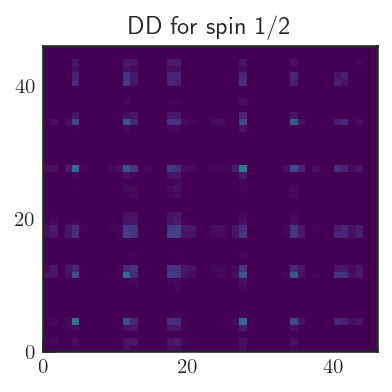

In [171]:
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(Fisher_dd_half), np.max(Fisher_dd_half))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# norm = colors.LogNorm(vmin=1e-3,vmax=1e5)
norm = colors.LogNorm(vmin=1e-2,vmax=1e5)
im = plt.pcolormesh(Fisher_dd_half, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher_dd_one.svg',dpi=150)
plt.title('DD for spin 1/2')


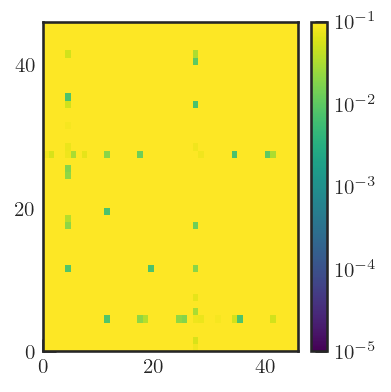

(0.007104470055529619, 176349955.2885201)

In [172]:
Inv_Fisher_dd_half = np.linalg.inv(Fisher_dd_half)
cov_dd_half = Inv_Fisher_dd_half #*1/steps
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(np.abs(cov_dd_half)), np.max(np.abs(cov_dd_half)))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-5,vmax=1e-1)
im = plt.pcolormesh(np.abs(cov_dd_half), norm=norm, cmap='viridis', rasterized=True)
cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
plt.show()
np.min(np.abs(cov_dd_half)), np.max(np.abs(cov_dd_half))


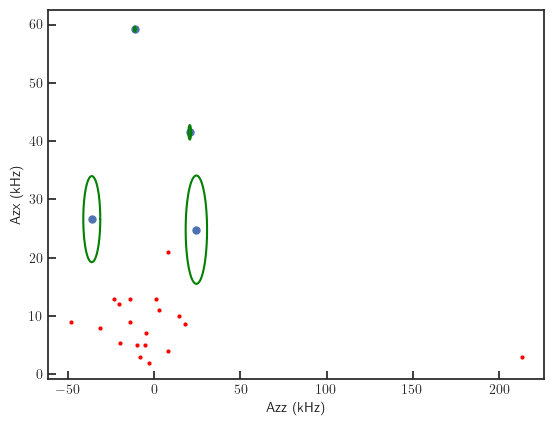

In [174]:
# np.min(Azz), np.max(Azz)
# x_Azz = np.linspace(-50, 250, 3000)
# y_Azx = np.linspace(0, 70, 1500)


t = np.linspace(0, 2*np.pi, 100)
plt.figure()
for i in range(len(Azz)):
    X = Azz[i]     #x-position of the center
    Y = Azx[i]    #y-position of the center
    Rx = np.sqrt(np.abs(cov_dd_half[i,i]))     #radius on the x-axis
    Ry = np.sqrt(np.abs(cov_dd_half[i+23,i+23]))   #radius on the y-axis
    if Rx<abs(X)**1 and Ry<abs(Y)**1:
        plt.plot(X, Y, 'o', markersize=5, color='C0')
        plt.plot( X+Rx*np.cos(t) , Y+Ry*np.sin(t) , color = 'green')
        
        x1 = Azz[i]     #x-position of the center
        y1 = Azx[i]    #y-position of the center
        Rx1 = np.sqrt(np.abs(cov_dd_half[i,i]))     #radius on the x-axis
        Ry1 = np.sqrt(np.abs(cov_dd_half[i+23,i+23]))   #radius on the y-axis
        for j in range(len(Azz)):
            if j<i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_dd_half[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_dd_half[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_dd_half[i,j]))
                if c>np.max([Rx1, Rx2]):
                    U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    plt.plot(U,V, color='orange')
                d = np.sqrt(np.abs(cov_dd_half[i+23,j+23]))
                if d>np.max([Ry1, Ry2]):
                    U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
                    plt.plot(U,V, color='pink')
    else:
        plt.plot(X, Y, 'o', markersize=2, color='red')
plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
# plt.xlim([-50,50])
plt.show()

<IPython.core.display.Javascript object>


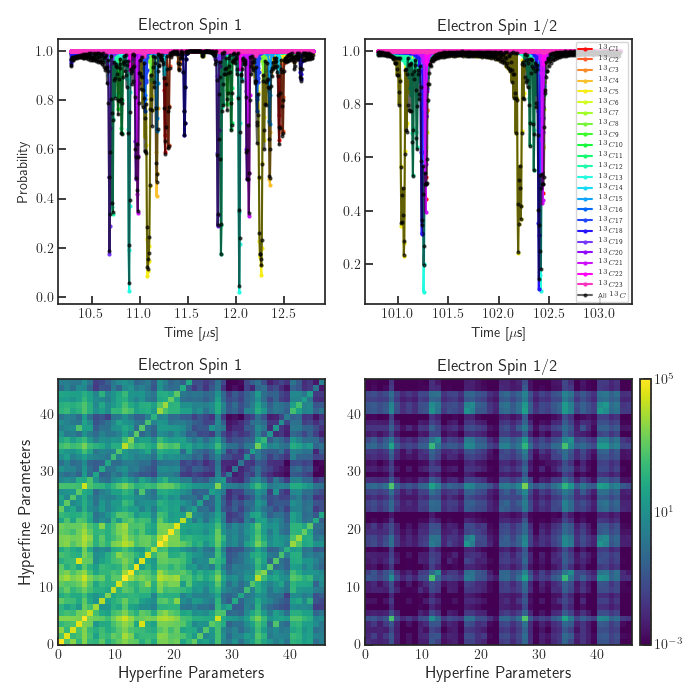

In [141]:
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
fig, ax = plt.subplots(2, 2, sharey=False, figsize=(7,7), constrained_layout=False)

start = 10.28e-3 # in ms
end = 12.8e-3
duration = end-start # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

All = []
for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=1, s0=0)
        Ang_0.append(0.5-0.5*sigma_z)
    ax[0,0].plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)
    
ax[0,0].plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')
ax[0,0].set_xlabel("Time [$\mu$s]")
ax[0,0].set_ylabel('Probability')
ax[0,0].set_title('Electron Spin 1')
# ax[0].legend(fontsize=7,loc=2)
#####################################################################################################
start = 100.8e-3 # in ms
duration = 2.4e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

All = []

for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=0.5, s0=-0.5)
        Ang_0.append(0.5-0.5*sigma_z)
    ax[0,1].plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    All.append(0.5-0.5*sigma_z)
    
ax[0,1].plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')

ax[0,1].set_xlabel("Time [$\mu$s]")
# ax[0,1].set_ylabel('Probability')
ax[0,1].legend(fontsize=5,loc=1)
ax[0,1].set_title('Electron Spin 1/2')
#####################################################################################################
levels = MaxNLocator(nbins=50).tick_values(np.min(Fisher_dd_one), np.max(Fisher_dd_one))
cmap = plt.get_cmap('PiYG')
norm = colors.LogNorm(vmin=1e-3,vmax=1e5)
im = ax[1,0].pcolormesh(Fisher_dd_one, norm=norm, cmap='viridis', rasterized=True)
ax[1,0].set_title('Electron Spin 1')
# cb=fig.colorbar(im, ax=ax[1,0],shrink=1)
# cb.set_ticks([1e-3, 1e1, 1e5]) # set ticks of your format
ax[1,0].set_xlabel('Hyperfine Parameters', fontsize=12)
ax[1,0].set_ylabel('Hyperfine Parameters', fontsize =12)
# ax[1,0].set_xticks([0, 20, 40])
# ax[1,0].set_yticks([0, 20, 40])
#####################################################################################################
im = ax[1,1].pcolormesh(Fisher_dd_half, norm=norm, cmap='viridis', rasterized=True)
ax[1,1].set_xlabel('Hyperfine Parameters', fontsize=12)
ax[1,1].set_title('Electron Spin 1/2')
cax = ax[1,1].inset_axes([ax[1,1].get_position().x1+0.13, 0, 0.04, 1])
cb = fig.colorbar(im, cax=cax)
cb.set_ticks([1e-3, 1e1, 1e5]) # set ticks of your format

# for n, axs in enumerate(ax.flat):
#     axs.text(-0.1, 1.1, string.ascii_lowercase[n]+'.', transform=axs.transAxes, size=15, weight='bold')

fig.tight_layout()
fig.savefig('dd_compare2.pdf',dpi=300)

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 6666.51it/s]


<IPython.core.display.Javascript object>


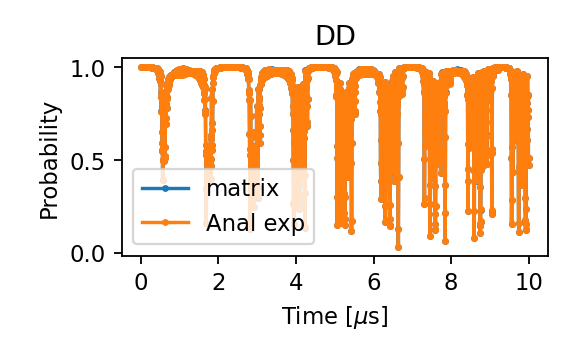

In [135]:
start = 10e-6 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

Signal = []
Signal_anal = []
for tau in tqdm(Taus):
    sigma_z = DD(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    Signal.append(sigma_z)
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    Signal_anal.append(sigma_z)
Signal = np.array(Signal)
Signal_anal = np.array(Signal_anal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p, '-o',markersize=2, alpha = 1, label='matrix')
plt.plot(Taus*1000, p_anal, '-o',markersize=2, alpha = 1, label='Anal exp')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('DD')
plt.legend()
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')

# 5 pulse ESEEM

In [120]:
def anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome_a = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome_b = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome_a, (OmeL+s0*Azz)/Ome_a
    nx, nz = s1*Azx/Ome_b, (OmeL+s1*Azz)/Ome_b
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome_a/Ome_b
    q = (s1-s0)*OmeL*Azx/Ome_a/Ome_b
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome_a/Ome_b
    

    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(s0*Azx, OmeL+s0*Azz)     ## specific for spin 1/2
    Eta_b = np.arctan2(s1*Azx, OmeL+s1*Azz)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    signal = 0.25*(np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4))
    return signal

def eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome0/Ome1
    
    ang_V0 = np.arccos(cos(Ome0*tau1/2)*cos(Ome1*tau1/2)-dot *sin(Ome0*tau1/2)*sin(Ome1*tau1/2))
    n_V0 = np.array([cos(Ome1*tau1/2)*sin(Ome0*tau1/2)*mx +cos(Ome0*tau1/2)*sin(Ome1*tau1/2)*nx,
                     -sin(Ome1*tau1/2)*sin(Ome0*tau1/2)*q,
                    cos(Ome1*tau1/2)*sin(Ome0*tau1/2)*mz +cos(Ome0*tau1/2)*sin(Ome1*tau1/2)*nz])
    n_V0 /=np.sqrt(np.sum(n_V0*n_V0, axis=0))
        
    ang_W0 = np.arccos(cos(Ome0*tau2/2)*cos(Ome1*tau2/2)-dot *sin(Ome0*tau2/2)*sin(Ome1*tau2/2))
    n_W0 = np.array([cos(Ome1*tau2/2)*sin(Ome0*tau2/2)*mx +cos(Ome0*tau2/2)*sin(Ome1*tau2/2)*nx,
                     -sin(Ome1*tau2/2)*sin(Ome0*tau2/2)*q,
                    cos(Ome1*tau2/2)*sin(Ome0*tau2/2)*mz +cos(Ome0*tau2/2)*sin(Ome1*tau2/2)*nz])
    n_W0 /=np.sqrt(np.sum(n_W0*n_W0, axis=0))
    
    
    V0 = np.array([ang_V0, n_V0[0], n_V0[1], n_V0[2]])
    V1d = np.array([ang_V0, -n_V0[0], n_V0[1], -n_V0[2]])
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    W0 = np.array([ang_W0, n_W0[0], n_W0[1], n_W0[2]])
    W1 = np.array([ang_W0, n_W0[0], -n_W0[1], n_W0[2]])
    
    V0V1d= mulVec(V0, V1d)
    W0F0 = mulVec(W0, F0)
    W0F1 = mulVec(W0, F1)
    W1F0 = mulVec(W1, F0)
    W1F1 = mulVec(W1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(W0F0, V0V1d), np.array([W1F0[0], -W1F0[1], -W1F0[2], -W1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(W1F0, V0V1d), np.array([W0F0[0], -W0F0[1], -W0F0[2], -W0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(W0F1, V0V1d), np.array([W1F1[0], -W1F1[1], -W1F1[2], -W1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(W1F1, V0V1d), np.array([W0F1[0], -W0F1[1], -W0F1[2], -W0F1[3]])))) 
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)


100%|██████████████████████████████████| 15000/15000 [00:09<00:00, 1615.74it/s]


<IPython.core.display.Javascript object>


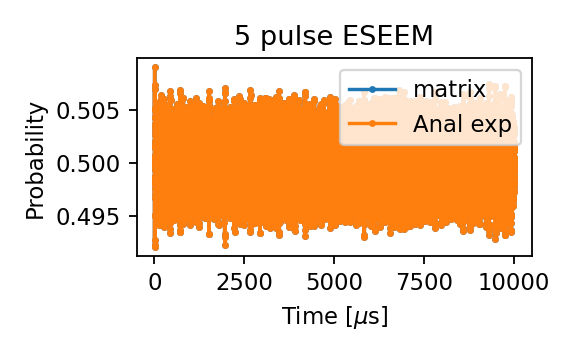

<IPython.core.display.Javascript object>


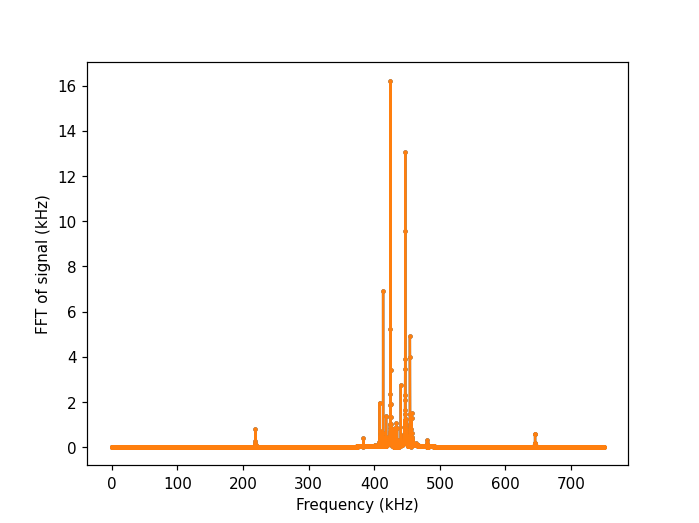

Text(0, 0.5, 'FFT of signal (kHz)')

In [58]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
#N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 1/469, 0.5/469

Signal = []
Signal_anal = []
for tc in tqdm(Tc):
    sigma_z = eseem(fL, Azz, Azx, tau1, tau2, tc, s1=-1, s0=1)
    Signal.append(sigma_z)
    sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=-1, s0=1)
    Signal_anal.append(sigma_z)
Signal = np.array(Signal)
Signal_anal = np.array(Signal_anal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Tc*1000, p, '-o',markersize=2, alpha = 1, label='matrix')
plt.plot(Tc*1000, p_anal, '-o',markersize=2, alpha = 1, label='Anal exp')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('5 pulse ESEEM')
plt.legend()
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT_p = np.abs(np.fft.rfft(p))[1:int(steps/2)]
FFT_p_anal = np.abs(np.fft.rfft(p_anal))[1:int(steps/2)]
plt.figure()
plt.plot(freqs, FFT_p, '-o',ms=2)
plt.plot(freqs, FFT_p_anal, '-o',ms=2)
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT of signal (kHz)')

100%|██████████████████████████████████| 15000/15000 [00:04<00:00, 3490.66it/s]


<IPython.core.display.Javascript object>


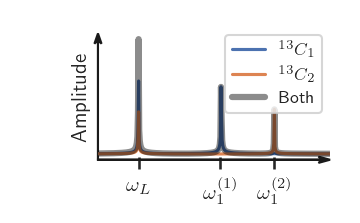

In [65]:
## only two close nuclei spin 1

######################################################

start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
#N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 1/469, 0.5/469
Ang_0 = []
Ang_1 = []
All = []
for tc in tqdm(Tc):
    sigma_z = anal_eseem(fL, Azz[3], Azx[3], tau1, tau2, tc, s1=-1, s0=0)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(fL, Azz[1], Azx[1], tau1, tau2, tc, s1=-1, s0=0)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(fL, Azz[1:4:2], Azx[1:4:2], tau1, tau2, tc, s1=-1, s0=0)
    All.append(0.5-0.5*sigma_z)
Signal0 = 0.5-0.5*np.array(Ang_0)
Signal1 = 0.5-0.5*np.array(Ang_1)
Signal = 0.5-0.5*np.array(All)
freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT0 = np.abs(np.fft.rfft(Signal0))[1:int(steps/2)]
FFT1 = np.abs(np.fft.rfft(Signal1))[1:int(steps/2)]
FFT = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.plot(freqs, FFT0, label=r'$^{13}C_1$')
plt.plot(freqs, FFT1, label=r'$^{13}C_2$')
plt.plot(freqs, FFT, alpha=0.45, linewidth=3, color='black', label='Both')
# plt.xlabel(r"$\omega$")
plt.ylabel('Amplitude')
plt.legend(loc=1)
plt.tight_layout()
plt.xlim([425, 465])
plt.xticks([432, 446.1, 455.4], [r'$\omega_L$', r'$\omega_1^{(1)}$', r'$\omega_1^{(2)}$'])
plt.yticks([])


fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', width = 0.0002, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.0002,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_eseem.svg',dpi=150)

In [67]:
## only two close nuclei spin 1 high coupling

######################################################

start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
#N_pi = 64 # number of pi pulses
N_meas = int(1e4)

fL = 40.34983*1.0705 # kHz
Apzz = np.concatenate((np.array([20*Azz[1], 20*Azz[3]]), Azz[4:]))
Apzx = np.concatenate((np.array([20*Azx[1], 20*Azx[3]]), Azx[4:]))

tau1, tau2 = 0.5/455, 0.5/455
Ang_0 = []
Ang_1 = []
All = []
for tc in tqdm(Tc):
    sigma_z = anal_eseem(fL, Azz[3]*20, Azx[3]*20, tau1, tau2, tc, s1=-1, s0=0)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(fL, Azz[1]*20, Azx[1]*20, tau1, tau2, tc, s1=-1, s0=0)
    Ang_1.append(0.5-0.5*sigma_z)
#     sigma_z = anal_eseem(fL, np.array([Azz[3]*5,Azz[1]]), np.array([Azx[3]*3,Azx[1]]), tau1, tau2, tc, s1=-1, s0=0)
#     All.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(fL, Apzz, Apzx, tau1, tau2, tc, s1=-1, s0=0)
    All.append(0.5-0.5*sigma_z)
Signal0 = 0.5-0.5*np.array(Ang_0)
Signal1 = 0.5-0.5*np.array(Ang_1)
Signal = 0.5-0.5*np.array(All)
freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT0 = np.abs(np.fft.rfft(Signal0))[1:int(steps/2)]
FFT1 = np.abs(np.fft.rfft(Signal1))[1:int(steps/2)]
FFT = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.plot(freqs, FFT0, label=r'$^{13}C_1$')
plt.plot(freqs, FFT1, label=r'$^{13}C_2$')
plt.plot(freqs, FFT, alpha=0.45, linewidth=3, color='black', label='All')
# plt.xlabel(r"$\omega$")
plt.ylabel('Amplitude')
plt.legend(loc=0)
plt.tight_layout()
plt.xlim([10, 630])
plt.xticks([43.5, 415, 569], [r'$\omega_L$', r'$\omega_1^{(1)}$', r'$\omega_1^{(2)}$'])
plt.yticks([])


fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', width = 0.0002, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.0002,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_eseem_high_A.svg',dpi=150)
fL = 403.4983*1.0705 # kHz

100%|██████████████████████████████████| 15000/15000 [00:04<00:00, 3376.53it/s]


<IPython.core.display.Javascript object>

In [285]:
np.array([Azz[3],Azz[1]])

array([-14.07, -23.22])

In [68]:
## only two close nuclei spin 1/2

######################################################

start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
#N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 1/469, 0.5/469
Ang_0 = []
Ang_1 = []
All = []
for tc in tqdm(Tc):
    sigma_z = anal_eseem(fL, Azz[3], Azx[3], tau1, tau2, tc, s1=-0.5, s0=0.5)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(fL, Azz[1], Azx[1], tau1, tau2, tc, s1=-0.5, s0=0.5)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(fL, Azz[1:4:2], Azx[1:4:2], tau1, tau2, tc, s1=-0.5, s0=0.5)
    All.append(0.5-0.5*sigma_z)
Signal0 = 0.5-0.5*np.array(Ang_0)
Signal1 = 0.5-0.5*np.array(Ang_1)
Signal = 0.5-0.5*np.array(All)
freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT0 = np.abs(np.fft.rfft(Signal0))[1:int(steps/2)]
FFT1 = np.abs(np.fft.rfft(Signal1))[1:int(steps/2)]
FFT = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.plot(freqs, FFT0, label=r'$^{13}C_1$')
plt.plot(freqs, FFT1, label=r'$^{13}C_2$')
plt.plot(freqs, FFT, alpha=0.45, linewidth=3, color='black', label='Both')
plt.axvline(431, color='black', linestyle='--')
# plt.xlabel(r"$\omega$")
plt.ylabel('Amplitude')
plt.legend(loc=1)
plt.tight_layout()
plt.xlim([417, 454])
plt.xticks([420.5, 425.1, 431, 439.1, 443.5],
           [r'$\omega_1^{(2)}$', r'$\omega_0^{(1)}$', r'$\omega_L$',r'$\omega_1^{(1)}$', r'$\omega_0^{(2)}$'])
plt.yticks([])


fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', width = 0.0002, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.0002,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_eseem_half.svg',dpi=150)

100%|██████████████████████████████████| 15000/15000 [00:04<00:00, 3581.27it/s]


<IPython.core.display.Javascript object>

100%|██████████████████████████████████| 15000/15000 [00:04<00:00, 3580.65it/s]


<IPython.core.display.Javascript object>


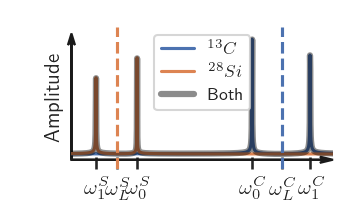

In [69]:
## only two close nuclei spin 1, two different species

######################################################

start = 1e-3 # in ms
duration = 8 # in ms
steps = 15000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
#N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 1.5/350, 0.5/469
fL1 = 403.4983*1.0705 # kHz Carbon
fL2 = 403.4983*(-0.8465) # kHz Silicon
Ang_0 = []
Ang_1 = []
All = []
for tc in tqdm(Tc):
    sigma_z = anal_eseem(fL1, Azz[3], Azx[3], tau1, tau2, tc, s1=1.5, s0=-0.5)
    Ang_0.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(fL2, Azz[7], Azx[7], tau1, tau2, tc, s1=1.5, s0=-0.5)
    Ang_1.append(0.5-0.5*sigma_z)
    sigma_z = anal_eseem(np.array([fL1, fL2]), Azz[3:8:4], Azx[3:8:4], tau1, tau2, tc, s1=1.5, s0=-0.5)
    All.append(0.5-0.5*sigma_z)
Signal0 = 0.5-0.5*np.array(Ang_0)
Signal1 = 0.5-0.5*np.array(Ang_1)
Signal = 0.5-0.5*np.array(All)
freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT0 = np.abs(np.fft.rfft(Signal0))[1:int(steps/2)]
FFT1 = np.abs(np.fft.rfft(Signal1))[1:int(steps/2)]
FFT = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]

plt.figure(dpi=150, figsize=(2.4,2.4/1.61803398875))
plt.plot(freqs, FFT0, label=r'$^{13}C$')
plt.plot(freqs, FFT1, label=r'$^{28}Si$')
plt.plot(freqs, FFT, alpha=0.45, linewidth=3, color='black', label='Both')
plt.axvline(425.7, color='C0', linestyle='--')
plt.axvline(346.8, color='C1', linestyle='--')
# plt.xlabel(r"$\omega$")
plt.ylabel('Amplitude')
plt.legend(loc=9)
plt.tight_layout()
plt.xlim([325, 450])
plt.xticks([336.7, 346.8, 356.3, 411.1, 425.7, 439.2],
           [r'$\omega_1^{S}$', r'$\omega_L^{S}$', r'$\omega_0^{S}$',
            r'$\omega_0^{C}$', r'$\omega_L^{C}$', r'$\omega_1^{C}$'])
plt.yticks([])


fig = plt.gcf()
ax = plt.gca()
xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)
# get width and height of axes object to compute 
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin) 
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
 

ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', width = 0.0002, 
         head_width=yhw, head_length=yhl, overhang = ohg, 
         length_includes_head= True, clip_on = False)

ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', width = 0.0002,  
         head_width=hw, head_length=hl, overhang = ohg, 
         length_includes_head= True, clip_on = False)


plt.show()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
plt.savefig('drawing_eseem_dual.svg',dpi=150)

In [170]:
fL2

-341.56131095

# DD-ESEEM

In [121]:
def ddeseem(fL, Azz, Azx, tau1, tau2, tc, N, s1=1, s0=-1): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome0/Ome1
    
    tau = tau1
    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    tau=tau2
    ang_WD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_WD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_WD0 /=np.sqrt(np.sum(n_WD0*n_WD0,axis=0))
    
    n_WD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_WD1 /=np.sqrt(np.sum(n_WD1*n_WD1,axis=0))
    
    
    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    WD0 = np.array([ang_WD0, n_WD0[0], n_WD0[1], n_WD0[2]])
    WD0d = np.array([ang_WD0, -n_WD0[0], -n_WD0[1], -n_WD0[2]])
    WD1 = np.array([ang_WD0, n_WD1[0], n_WD1[1], n_WD1[2]])
    WD1d = np.array([ang_WD0, -n_WD1[0], -n_WD1[1], -n_WD1[2]])
    
    VD0VD1d= mulVec(VD0, VD1d)
    WD0F0 = mulVec(WD0, F0)
    WD0F1 = mulVec(WD0, F1)
    WD1F0 = mulVec(WD1, F0)
    WD1F1 = mulVec(WD1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]]))))

#     F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
#     F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
#     F0dWD1d = mulVec(F0d, WD1d)
#     F0dWD0d = mulVec(F0d, WD0d)
#     F1dWD1d = mulVec(F1d, WD1d)
#     F1dWD0d = mulVec(F1d, WD0d)
    
#     W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), F0dWD1d)))
#     W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), F0dWD0d)))
#     W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), F1dWD1d)))
#     W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), F1dWD0d)))
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)

def DD(fL, Azz, Azx, tau, N, s1=1, s0=-1): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

# Checking DD ESEEM with brute force matrix multiplication

In [118]:
from qutip import *
Iz = 0.5*sigmaz()
Ix = 0.5*sigmax()
Iy = 0.5*sigmay()
Ie = qeye(2)*0.5

def dd_pulse_ESEEM_matrix(fL, Azz, Azx, tau1, tau2, Tc, N=1, s1=1,s0=-1):
    # N = number of pi pulses (even or odd), at each hahn-echo, tau-2tau-2tau-2tau-...
    WL, Azz, Azx = 2*pi*fL, 2*pi*Azz, 2*pi*Azx
    term1, term2, term3, term4 = [], [], [], []
    for i, azz in enumerate(Azz):
        H0 = (WL+s0*azz)*Iz+s0*Azx[i]*Ix
        H1 = (WL+s1*azz)*Iz+s1*Azx[i]*Ix
        u0 = ((-1j*H1*tau1).expm())*((-1j*H0*tau1).expm())
        u1 = ((-1j*H0*tau1).expm())*((-1j*H1*tau1).expm())
        W0 = (-1j*H0*Tc).expm()
        W1 = (-1j*H1*Tc).expm()
        v0 = ((-1j*H1*tau2).expm())*((-1j*H0*tau2).expm())
        v1 = ((-1j*H0*tau2).expm())*((-1j*H1*tau2).expm())

        if N==1:
            term1.append(real((v1*W0*u0*(u1.dag())*(W0.dag())*(v0.dag())).tr()*0.5))
            term2.append(real((v0*W0*u0*(u1.dag())*(W0.dag())*(v1.dag())).tr()*0.5))
            term3.append(real((v1*W1*u0*(u1.dag())*(W1.dag())*(v0.dag())).tr()*0.5))
            term4.append(real((v0*W1*u0*(u1.dag())*(W1.dag())*(v1.dag())).tr()*0.5))
            
        else:
            U0 = (u0**(N%2)) * ((u1*u0)**(N//2))
            U1 = (u1**(N%2)) * ((u0*u1)**(N//2))
            V0 = (v0**(N%2)) * ((v1*v0)**(N//2))
            V1 = (v1**(N%2)) * ((v0*v1)**(N//2))
            term1.append(real((V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()*0.5))
            term2.append(real((V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()*0.5))
            term3.append(real((V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()*0.5))
            term4.append(real((V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()*0.5))
    sigma_z = -0.25*(np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4))
    return sigma_z
            

ModuleNotFoundError: No module named 'qutip'

100%|████████████████████████████████████████| 150/150 [00:25<00:00,  5.92it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


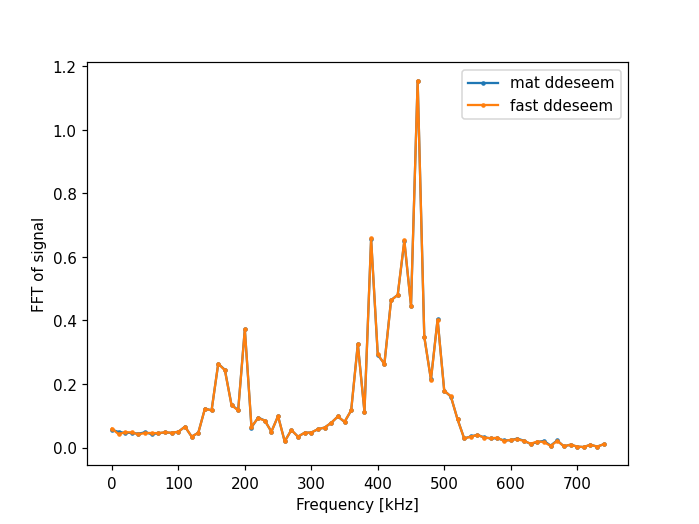

Text(0, 0.5, 'FFT of signal')

In [61]:
start = 1e-3 # in ms
duration = 0.1 # in ms
steps = 150
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
tau1, tau2 = 0.75/441, 0.75/441
n_pi= 2000
mat_ddeseem = []
fast_ddeseem=[]
for tc in tqdm(Tc):

    mat_ddeseem.append(dd_pulse_ESEEM_matrix(fL, Azz, Azx, tau1, tau2, tc,N=n_pi, s1=1, s0=-1))
    fast_ddeseem.append(ddeseem(fL, Azz, Azx, tau1, tau2, tc, n_pi, s1=1, s0=-1))
mat_ddeseem= np.array(mat_ddeseem)
# p=0.5-0.5*mat_ddeseem
# p/=np.max(p)
fast_ddeseem= np.array(fast_ddeseem)
# p5=0.5-0.5*fast_ddeseem
# p5/=np.max(p5)

plt.figure()
plt.plot(Tc*1000, mat_ddeseem, '-o',markersize=2, alpha = 1, label='mat ddeseem')
plt.plot(Tc*1000, fast_ddeseem, '-o',markersize=2, alpha = 1, label='fast ddeseem')
plt.legend()
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')

fig,ax = plt.subplots()
f =fftfreq(steps, 1/sample_rate)[0:int(steps/2)]
ax.plot(f, np.abs(fft(mat_ddeseem))[0:int(steps/2)],'-o',markersize=2, alpha = 1, label='mat ddeseem')
ax.plot(f, np.abs(fft(fast_ddeseem))[0:int(steps/2)],'-o',markersize=2, alpha = 1, label='fast ddeseem')
plt.legend()
ax.set_xlabel('Frequency [kHz]')
ax.set_ylabel('FFT of signal')

# DDESEEM with different number of \pi pulses at larmor bright spot

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1705.35it/s]


<IPython.core.display.Javascript object>

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1736.65it/s]


<IPython.core.display.Javascript object>

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1713.65it/s]


<IPython.core.display.Javascript object>

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1745.42it/s]


<IPython.core.display.Javascript object>


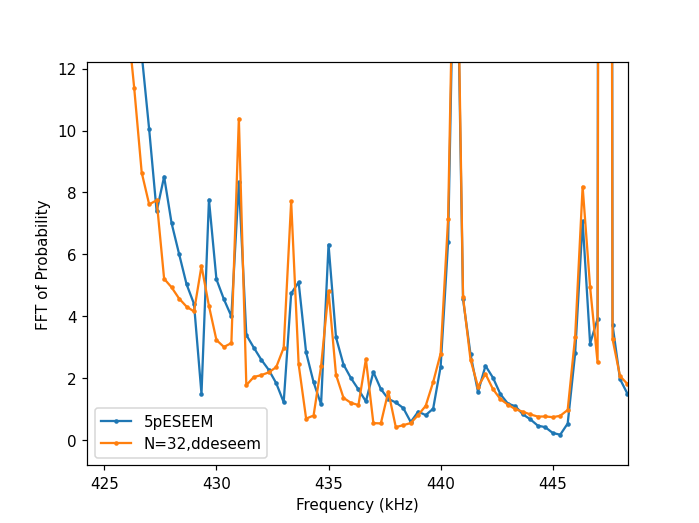

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1731.24it/s]


<IPython.core.display.Javascript object>

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1758.57it/s]


<IPython.core.display.Javascript object>


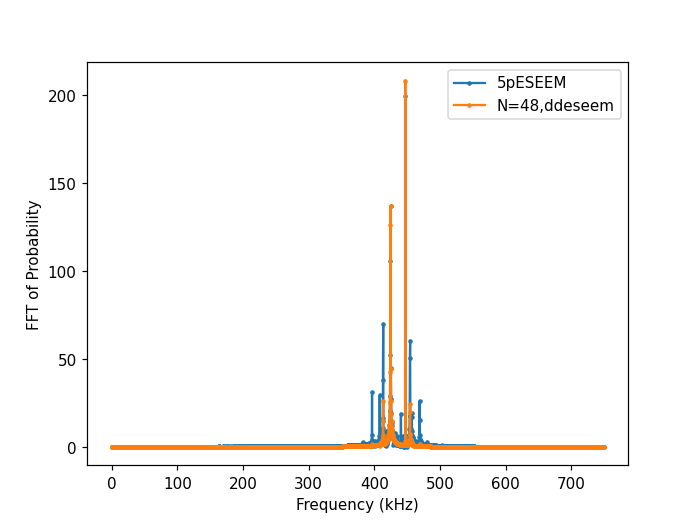

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1738.22it/s]


<IPython.core.display.Javascript object>


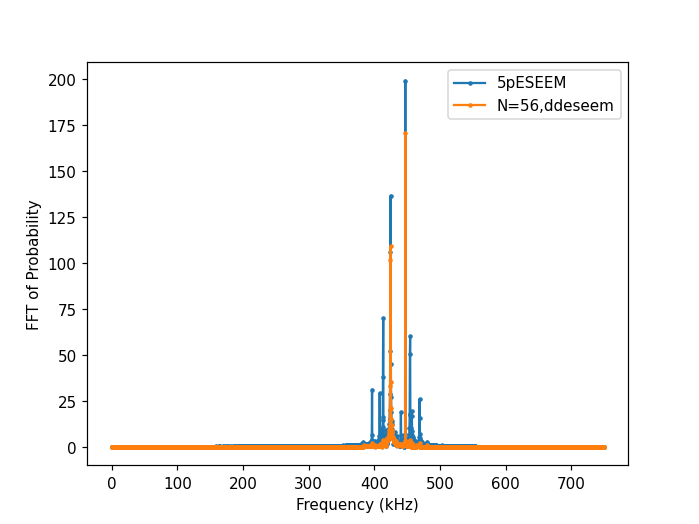

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1751.50it/s]


<IPython.core.display.Javascript object>

In [955]:
start = 1e-3 # in ms
duration = 3 # in ms
steps = 4500
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 0.5/441, 0.5/441

for N_pi in np.arange(8,65,8):
    DDeseem = []
    eseem5p = []
    for tc in tqdm(Tc):
        sigma_z = ddeseem(fL, Azz, Azx, tau1, tau2, tc, N_pi, s1=1, s0=-1)
        DDeseem.append(sigma_z)
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1)
        eseem5p.append(sigma_z)
    DDeseem = np.array(DDeseem)
    eseem5p = np.array(eseem5p)
    p_eseem = 0.5-0.5*DDeseem # probability to be in the initial state (bright state)
    p_5p = 0.5-0.5*eseem5p # probability to be in the initial state (bright state)
    #p_noisy = Generate_noisy_signal(p, N_meas)

#     plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
#     plt.plot(Tc*1000, p_eseem, '-o',markersize=2, alpha = 1, label='matrix')
#     plt.plot(Tc*1000, p_5p, '-o',markersize=2, alpha = 1, label='Anal exp')
#     plt.xlabel("Time [$\mu$s]")
#     plt.ylabel('Probability')
#     plt.title('5 pulse ESEEM')
#     plt.legend()
#     plt.tight_layout()
#     #plt.savefig('HE_behavior.pdf')

    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_ddeseem = np.abs(np.fft.rfft(DDeseem))[1:int(steps/2)]
    FFT_5p = np.abs(np.fft.rfft(eseem5p))[1:int(steps/2)]
    plt.figure()
    plt.plot(freqs, FFT_5p,'-o',markersize=2, alpha = 1, label=r'5pESEEM')
    plt.plot(freqs, FFT_ddeseem,'-o',markersize=2, alpha = 1, label=r'N={},ddeseem'.format(N_pi))
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('FFT of Probability')
    plt.legend()

# What is the best number of pulse for each nuclear spin?

In [960]:
def angle_ddeseem(fL, Azz, Azx, tau, s1=1, s0=-1): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    
    return np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
angles = angle_ddeseem(fL, Azz, Azx, tau1, s1=1, s0=-1)*180/pi
angles 

array([7.26790302, 7.2508967 , 7.34498343, 7.23703799, 4.24151822,
       7.358698  , 7.38335879, 7.36834591, 7.454945  , 7.32605246,
       7.30052371, 5.95562391, 6.97429561, 7.36741182, 7.31754526,
       7.34488254, 7.36796435, 6.94640601, 6.89243283, 7.27542292,
       7.22901705, 7.37668245, 7.38804427])

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1729.22it/s]


<IPython.core.display.Javascript object>


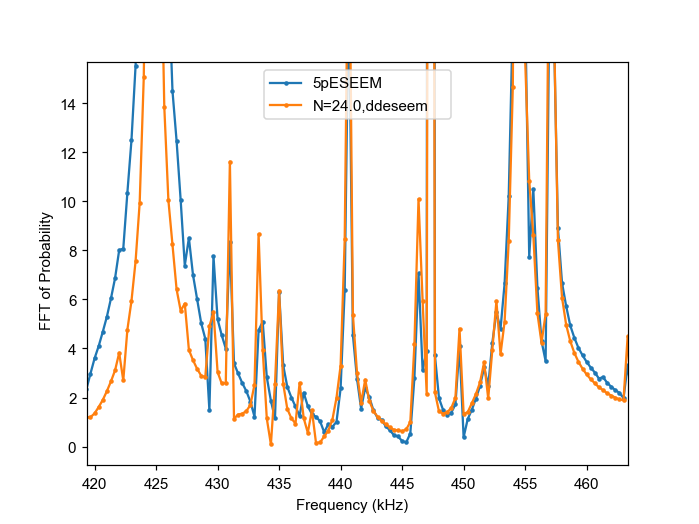

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1736.97it/s]


<IPython.core.display.Javascript object>


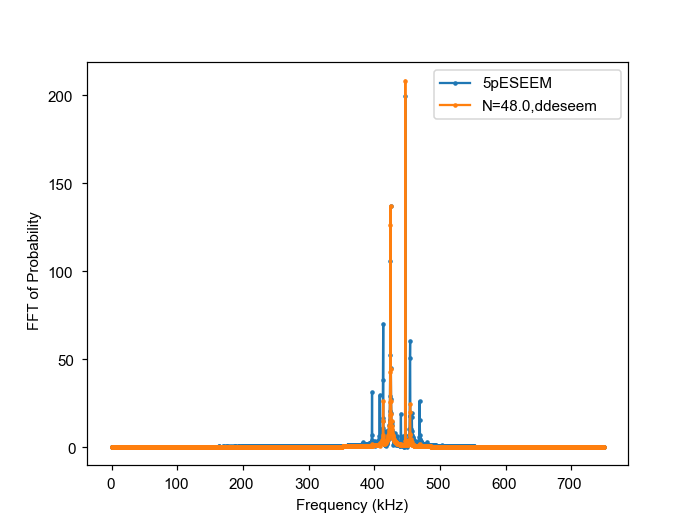

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1763.56it/s]


<IPython.core.display.Javascript object>

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1728.57it/s]


<IPython.core.display.Javascript object>


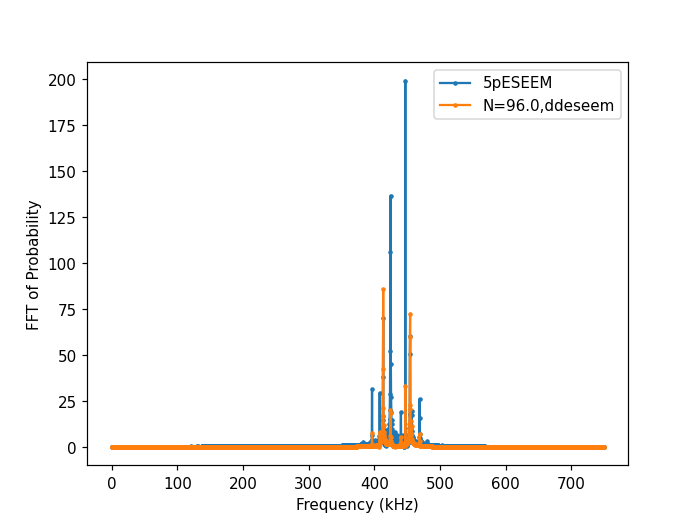

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1752.78it/s]


<IPython.core.display.Javascript object>


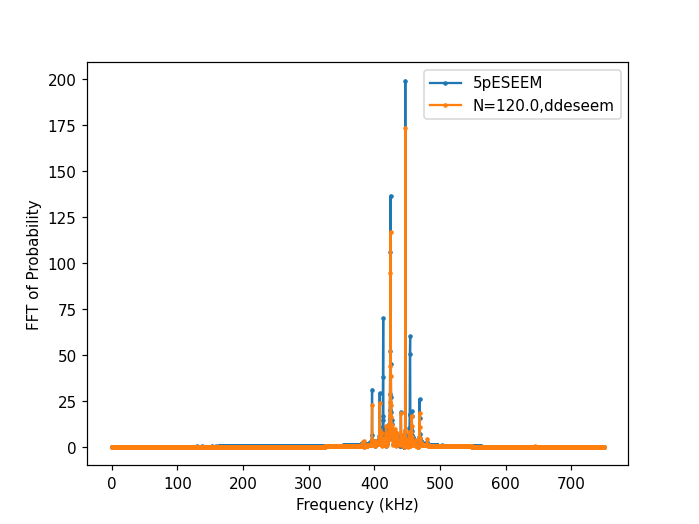

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1765.98it/s]


<IPython.core.display.Javascript object>


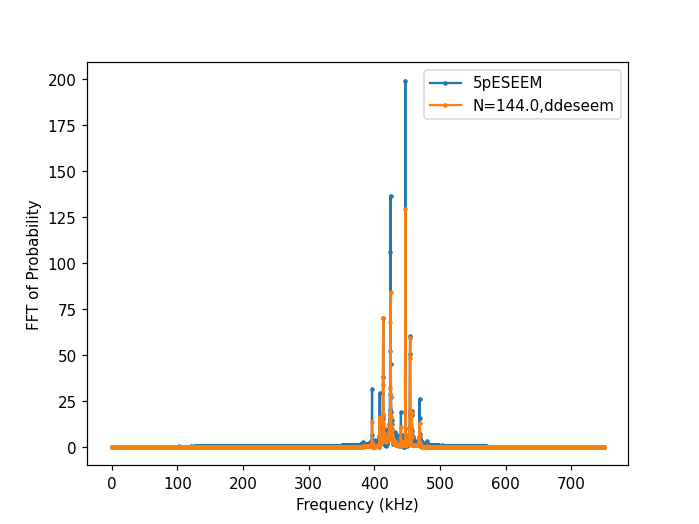

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1758.43it/s]
C:\Users\majid\AppData\Local\Temp\ipykernel_4540\749455894.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


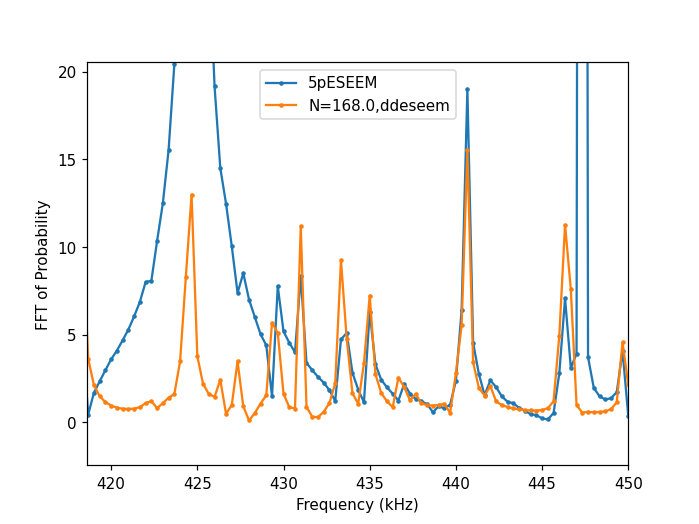

In [961]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 0.5/441, 0.5/441

for N_pi in np.arange(1,8,1)*np.round(180/angles[-1]):
    DDeseem = []
    eseem5p = []
    for tc in tqdm(Tc):
        sigma_z = ddeseem(fL, Azz, Azx, tau1, tau2, tc, N_pi, s1=1, s0=-1)
        DDeseem.append(sigma_z)
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1)
        eseem5p.append(sigma_z)
    DDeseem = np.array(DDeseem)
    eseem5p = np.array(eseem5p)
    p_eseem = 0.5-0.5*DDeseem # probability to be in the initial state (bright state)
    p_5p = 0.5-0.5*eseem5p # probability to be in the initial state (bright state)
    #p_noisy = Generate_noisy_signal(p, N_meas)

#     plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
#     plt.plot(Tc*1000, p_eseem, '-o',markersize=2, alpha = 1, label='matrix')
#     plt.plot(Tc*1000, p_5p, '-o',markersize=2, alpha = 1, label='Anal exp')
#     plt.xlabel("Time [$\mu$s]")
#     plt.ylabel('Probability')
#     plt.title('5 pulse ESEEM')
#     plt.legend()
#     plt.tight_layout()
#     #plt.savefig('HE_behavior.pdf')

    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_ddeseem = np.abs(np.fft.rfft(DDeseem))[1:int(steps/2)]
    FFT_5p = np.abs(np.fft.rfft(eseem5p))[1:int(steps/2)]
    plt.figure()
    plt.plot(freqs, FFT_5p,'-o',markersize=2, alpha = 1, label=r'5pESEEM')
    plt.plot(freqs, FFT_ddeseem,'-o',markersize=2, alpha = 1, label=r'N={},ddeseem'.format(N_pi))
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('FFT of Probability')
    plt.legend()

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1507.18it/s]


<IPython.core.display.Javascript object>


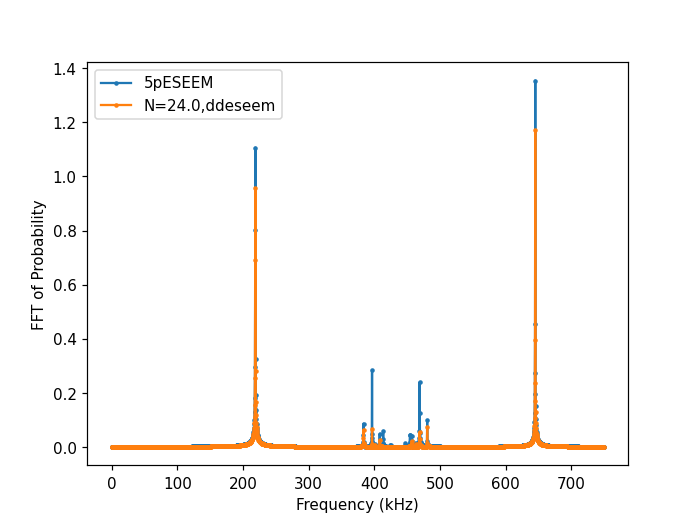

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1525.50it/s]


<IPython.core.display.Javascript object>


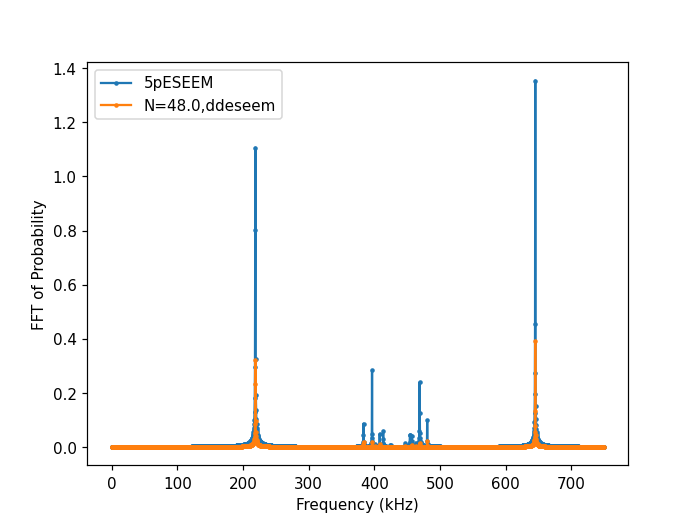

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1537.15it/s]


<IPython.core.display.Javascript object>


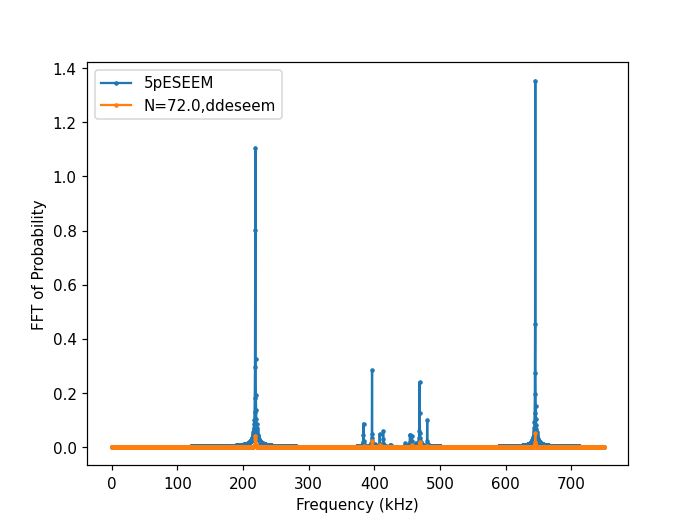

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1545.47it/s]


<IPython.core.display.Javascript object>


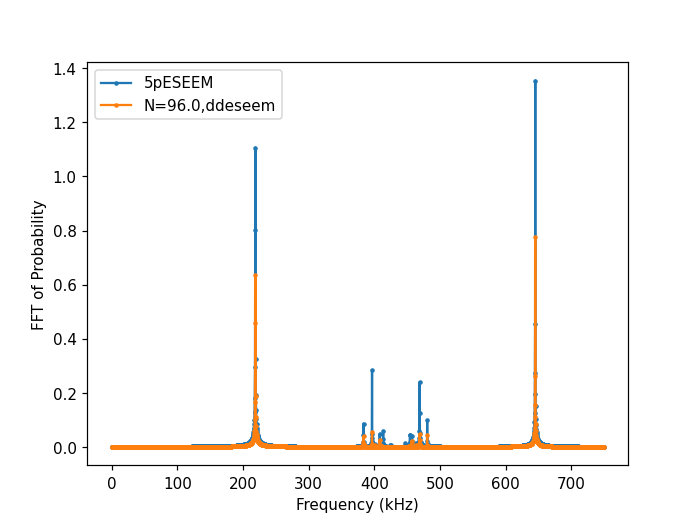

100%|████████████████████████████████████| 4500/4500 [00:02<00:00, 1532.61it/s]


<IPython.core.display.Javascript object>


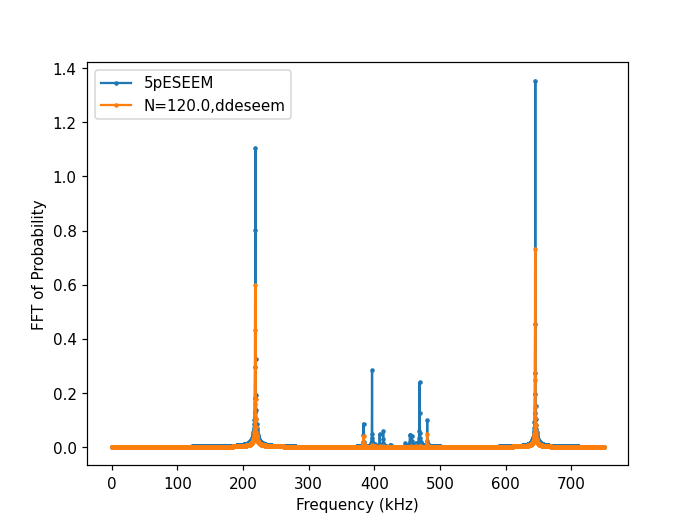

In [972]:
start = 1e-3 # in ms
duration = 3 # in ms
steps = 4500
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 0.5/218, 0.5/219

for N_pi in np.arange(1,6,1)*np.round(180/angles[8]):
    DDeseem = []
    eseem5p = []
    for tc in tqdm(Tc):
        sigma_z = ddeseem(fL, Azz, Azx, tau1, tau2, tc, N_pi, s1=1, s0=-1)
        DDeseem.append(sigma_z)
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1)
        eseem5p.append(sigma_z)
    DDeseem = np.array(DDeseem)
    eseem5p = np.array(eseem5p)
    p_eseem = 0.5-0.5*DDeseem # probability to be in the initial state (bright state)
    p_5p = 0.5-0.5*eseem5p # probability to be in the initial state (bright state)
    #p_noisy = Generate_noisy_signal(p, N_meas)

#     plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
#     plt.plot(Tc*1000, p_eseem, '-o',markersize=2, alpha = 1, label='matrix')
#     plt.plot(Tc*1000, p_5p, '-o',markersize=2, alpha = 1, label='Anal exp')
#     plt.xlabel("Time [$\mu$s]")
#     plt.ylabel('Probability')
#     plt.title('5 pulse ESEEM')
#     plt.legend()
#     plt.tight_layout()
#     #plt.savefig('HE_behavior.pdf')

    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_ddeseem = np.abs(np.fft.rfft(DDeseem))[1:int(steps/2)]
    FFT_5p = np.abs(np.fft.rfft(eseem5p))[1:int(steps/2)]
    plt.figure()
    plt.plot(freqs, FFT_5p,'-o',markersize=2, alpha = 1, label=r'5pESEEM')
    plt.plot(freqs, FFT_ddeseem,'-o',markersize=2, alpha = 1, label=r'N={},ddeseem'.format(N_pi))
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('FFT of Probability')
    plt.legend()

# Advantage of 5pESEEM to DD for SiV

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 26835.22it/s]


<IPython.core.display.Javascript object>


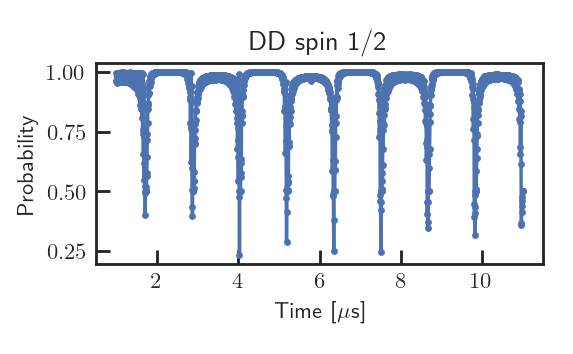

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 25472.98it/s]


<IPython.core.display.Javascript object>


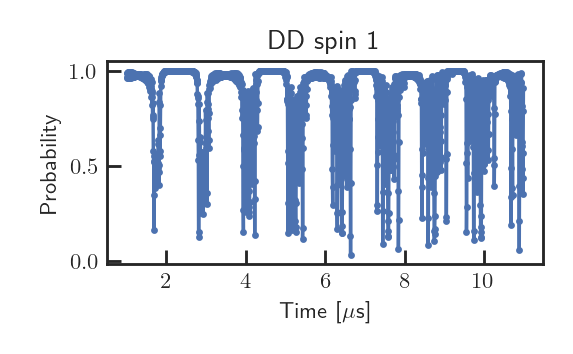

In [71]:
start = 1e-3 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)


Signal_anal = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    Signal_anal.append(sigma_z)

Signal_anal = np.array(Signal_anal)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_anal, '-o',markersize=2, alpha = 1)
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('DD spin 1/2')
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')
###################################################
Signal_anal = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    Signal_anal.append(sigma_z)

Signal_anal = np.array(Signal_anal)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_anal, '-o',markersize=2, alpha = 1)
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('DD spin 1')
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')



100%|██████████████████████████████████| 15000/15000 [00:02<00:00, 5130.52it/s]


<IPython.core.display.Javascript object>


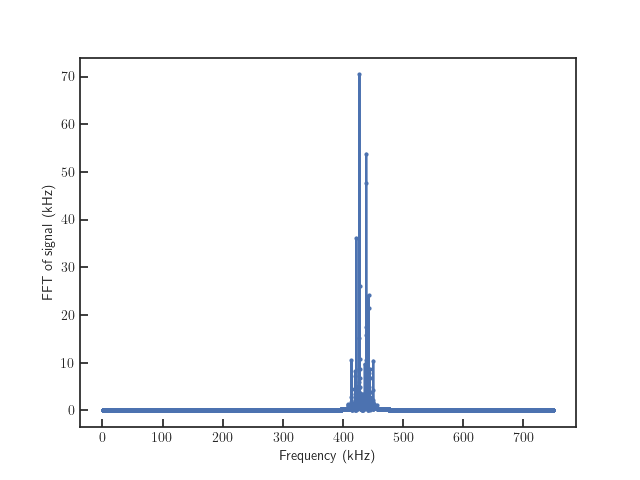

Text(0, 0.5, 'FFT of signal (kHz)')

In [165]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
#N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1 = 3.5/645
tau2= tau1

Signal_anal = []
for tc in tqdm(Tc):
    sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=0.5, s0=-0.5)
    Signal_anal.append(sigma_z)
Signal_anal = np.array(Signal_anal)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
# plt.plot(Tc*1000, p_anal, '-o',markersize=2, alpha = 1, label='Anal exp')
# plt.xlabel("Time [$\mu$s]")
# plt.ylabel('Probability')
# plt.title('5 pulse ESEEM')
# plt.legend()
# plt.tight_layout()
# #plt.savefig('HE_behavior.pdf')

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT_p_anal = np.abs(np.fft.rfft(p_anal))[1:int(steps/2)]
plt.figure()
plt.plot(freqs, FFT_p_anal, '-o',ms=2)
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT of signal (kHz)')
# plt.xlim([380, 485])

# plots for thesis

In [981]:
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 1.5, "ytick.major.size": 1.5, 
                        "xtick.direction": "in","ytick.direction": "in"})
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend',fontsize=8)
cmap = sns.color_palette(n_colors=10)

In [119]:
start = 1e-3 # in ms
duration = 4 # in ms
steps = 6000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)
tau1, tau2 = 0.5/442, 0.5/442

for N_pi in [72]:
    DDeseem = []
    eseem5p = []
    for tc in tqdm(Tc):
        sigma_z = ddeseem(fL, Azz, Azx, tau1, tau2, tc, N_pi, s1=1, s0=-1)
        DDeseem.append(sigma_z)
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1)
        eseem5p.append(sigma_z)
    DDeseem = np.array(DDeseem)
    eseem5p = np.array(eseem5p)
    p_eseem = 0.5-0.5*DDeseem # probability to be in the initial state (bright state)
    p_5p = 0.5-0.5*eseem5p # probability to be in the initial state (bright state)
    #p_noisy = Generate_noisy_signal(p, N_meas)

#     plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
#     plt.plot(Tc*1000, p_eseem, '-o',markersize=2, alpha = 1, label='matrix')
#     plt.plot(Tc*1000, p_5p, '-o',markersize=2, alpha = 1, label='Anal exp')
#     plt.xlabel("Time [$\mu$s]")
#     plt.ylabel('Probability')
#     plt.title('5 pulse ESEEM')
#     plt.legend()
#     plt.tight_layout()
#     #plt.savefig('HE_behavior.pdf')

    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_ddeseem = np.abs(np.fft.rfft(DDeseem))[1:int(steps/2)]
    FFT_5p = np.abs(np.fft.rfft(eseem5p))[1:int(steps/2)]
    plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
    plt.plot(freqs, FFT_5p,'-o',markersize=2, alpha = 1, label=r'5pESEEM')
    plt.plot(freqs, FFT_ddeseem,'-o',markersize=2, alpha = 1, label=r'N={},ddeseem'.format(N_pi))
    plt.axvline(x=fL, linestyle='--',color='gray')
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('FFT of Probability')
    plt.legend()
#     plt.xlim([420, 442])
#     plt.ylim([0, 20])
    plt.tight_layout()
# plt.savefig('ddeseem.pdf')
x2= freqs
y22 = FFT_ddeseem
y21 = FFT_5p

100%|████████████████████████████████████| 6000/6000 [00:04<00:00, 1238.18it/s]


<IPython.core.display.Javascript object>

# plot for paper

100%|██████████████████████████████████| 45000/45000 [00:08<00:00, 5160.37it/s]


<IPython.core.display.Javascript object>


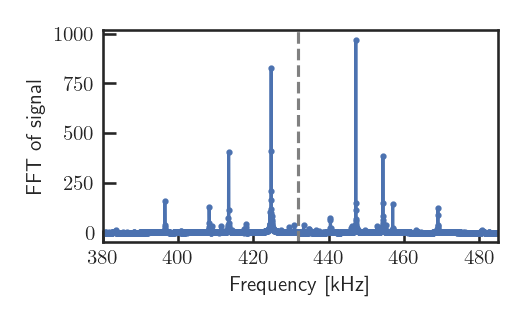

In [120]:
start = 1e-3 # in ms
duration = 30 # in ms
steps = 45000
Tc = np.linspace(start,start+duration, steps) # in ms
N_meas = int(1e4)
sample_rate = steps/duration # in kHz
#fig_all,ax_all = plt.subplots(dpi=100)

for tau1, tau2, txt in [[0.5/440, 0.5/440, 'nothing blinded']]:

    Signal = []
    
    for tc in tqdm(Tc):
        signal= anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1,s0=-1)
        Signal.append(signal)
    Signal = np.array(Signal)
    p = 0.5-0.5*Signal # probability to come back to initial state (bright state)
#     p_noisy = Generate_noisy_signal(p, N_meas)
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(p))[1:int(steps/2)]

    
    plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
    plt.plot(freqs, FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))))
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('FFT of signal')
    plt.axvline(x=fL, linestyle='--',color='gray')
    plt.xlim([380, 485])
    plt.tight_layout()
    #plt.savefig('DQR_high_res.pdf')
    
#     ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))
#                    +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )

# ax_all.set_title('all plots')
# ax_all.set_xlabel('Frequency [kHz]')
# ax_all.set_ylabel('FFT of signal')
# ax_all.legend(loc='upper right')
# ax_all.grid()

x1=freqs
y1=FFT_Signal

# Fisher infor for 5pESEEM spin 1

In [126]:
start = 1e-3 # in ms
duration = 1000 # in ms
steps = 1500
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
s1, s0 = 1, -1
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_tau = np.zeros([len(A),len(A)])
Fisher_one = np.zeros([len(A),len(A)])
tau1 = tau2 = 0.5/440

def PSD(fL, Azz, Azx, tau1, tau2, Tc, s1=s1, s0=s0):
    Sigma_z = []
    for tc in Tc:
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=s1, s0=s0)
        Sigma_z.append(sigma_z)
    Sigma_z = np.array(Sigma_z)
    pp = 0.5-0.5*Sigma_z # probability to be in the initial state (bright state)
    FFT_pp = np.abs(np.fft.rfft(pp))[1:int(steps/2)]
    return FFT_pp**2/np.sum(FFT_pp**2)

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
p = PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0)
for i in tqdm(range(len(A))):
    Azzp = Azz.copy()
    Azxp = Azx.copy()
    if i<23: Azzp[i] = Azz[i]+eps
    else:    Azxp[i-23] = Azx[i-23]+eps
    Di=(PSD(fL,Azzp,Azxp,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps

    for j in range(len(A)):
        Azzq = Azz.copy()
        Azxq = Azx.copy()
        if j<23: Azzq[j] = Azz[j]+eps
        else:    Azxq[j-23] = Azx[j-23]+eps
        Dj=(PSD(fL,Azzq,Azxq,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps
#         Fisher_tau[i][j] = 1/p * Di* Dj
        Fisher_one[i][j] = np.sum(np.abs(1/p * Di* Dj))
# Fisher += Fisher_tau
print(np.min(Fisher_one), np.max(Fisher_one))

100%|██████████| 46/46 [30:01<00:00, 39.17s/it]

2.502255896235819e-05 4415116.047707592


In [182]:
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
# plt.pcolormesh(Fisher_eseem_one, norm=norm, cmap='viridis', rasterized=True)
levels = MaxNLocator(nbins=100).tick_values(np.min(Fisher_one), np.max(Fisher_one))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-4,vmax=1e3)
im = plt.pcolormesh(Fisher_one, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12) 
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher_eseem_one.svg',dpi=150)

([<matplotlib.axis.YTick at 0x26c04a61a50>,
 [Text(0, 0, '$\\mathdefault{0}$'),
  Text(0, 20, '$\\mathdefault{20}$'),
  Text(0, 40, '$\\mathdefault{40}$')])

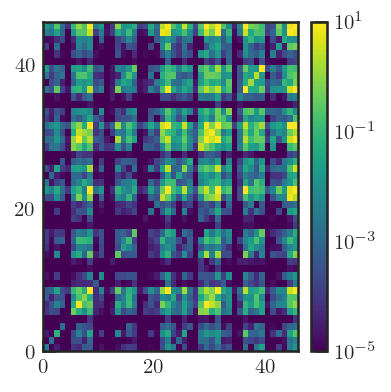

In [183]:
Inv_Fisher_eseem_one= np.linalg.inv(Fisher_one)
cov_eseem_one = Inv_Fisher_eseem_one #*1/steps
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(np.abs(cov_eseem_one)), np.max(np.abs(cov_eseem_one)))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-5,vmax=1e1)
im = plt.pcolormesh(np.abs(cov_eseem_one), norm=norm, cmap='viridis', rasterized=True)
cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
np.min(np.abs(cov_eseem_one)), np.max(np.abs(cov_eseem_one))
plt.show()

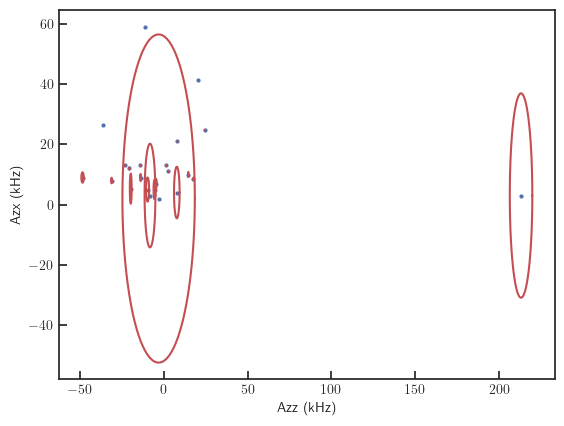

In [184]:
# np.min(Azz), np.max(Azz)
# x_Azz = np.linspace(-50, 250, 3000)
# y_Azx = np.linspace(0, 70, 1500)


t = np.linspace(0, 2*np.pi, 100)
plt.figure()
plt.plot(Azz, Azx, 'o', markersize=2)
for i in range(len(Azz)):
    X = Azz[i]     #x-position of the center
    Y = Azx[i]    #y-position of the center
    Rx = np.sqrt(cov_eseem_one[i,i])     #radius on the x-axis
    Ry = np.sqrt(cov_eseem_one[i+23,i+23])   #radius on the y-axis
    plt.plot( X+Rx*np.cos(t) , Y+Ry*np.sin(t) , color = 'r')
plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
# plt.xlim([-50,50])
plt.show()

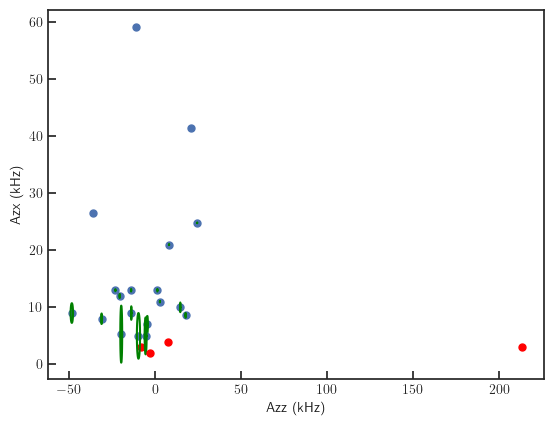

In [185]:
# np.min(Azz), np.max(Azz)
# x_Azz = np.linspace(-50, 250, 3000)
# y_Azx = np.linspace(0, 70, 1500)


t = np.linspace(0, 2*np.pi, 100)
plt.figure()
for i in range(len(Azz)):
    X = Azz[i]     #x-position of the center
    Y = Azx[i]    #y-position of the center
    Rx = np.sqrt(np.abs(cov_eseem_one[i,i]))     #radius on the x-axis
    Ry = np.sqrt(np.abs(cov_eseem_one[i+23,i+23]))   #radius on the y-axis
    if Rx<abs(X) and Ry<abs(Y):
        plt.plot(X, Y, 'o', markersize=5, color='C0')
        plt.plot( X+Rx*np.cos(t) , Y+Ry*np.sin(t) , color = 'green')
    else:
        plt.plot(X, Y, 'o', markersize=5, color='red')
plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
# plt.xlim([-50,50])
plt.show()

In [123]:
start = 1e-3 # in ms
duration = 100 # in ms
steps = 5000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
s1, s0 = 0.5, -0.5
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_tau = np.zeros([len(A),len(A)])
Fisher_onehalf = np.zeros([len(A),len(A)])
tau1 = tau2 = 0.5/440

def PSD(fL, Azz, Azx, tau1, tau2, Tc, s1=s1, s0=s0):
    Sigma_z = []
    for tc in Tc:
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=s1, s0=s0)
        Sigma_z.append(sigma_z)
    Sigma_z = np.array(Sigma_z)
    pp = 0.5-0.5*Sigma_z # probability to be in the initial state (bright state)
    FFT_pp = np.abs(np.fft.rfft(pp))[1:int(steps/2)]
    return FFT_pp**2/np.sum(FFT_pp**2)

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
p = PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0)
for i in tqdm(range(len(A))):
    Azzp = Azz.copy()
    Azxp = Azx.copy()
    if i<23: Azzp[i] = Azz[i]+eps
    else:    Azxp[i-23] = Azx[i-23]+eps
    Di=(PSD(fL,Azzp,Azxp,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps

    for j in range(len(A)):
        Azzq = Azz.copy()
        Azxq = Azx.copy()
        if j<23: Azzq[j] = Azz[j]+eps
        else:    Azxq[j-23] = Azx[j-23]+eps
        Dj=(PSD(fL,Azzq,Azxq,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps
#         Fisher_tau[i][j] = 1/p * Di* Dj
        Fisher_onehalf[i][j] = np.sum(np.abs(1/p * Di* Dj))
# Fisher += Fisher_tau
print(np.min(Fisher_onehalf), np.max(Fisher_onehalf))

100%|████████████████████████████████████████| 46/46 [1:05:57<00:00, 86.04s/it]

2.7035443671745424e-08 18713.772963309257


<IPython.core.display.Javascript object>


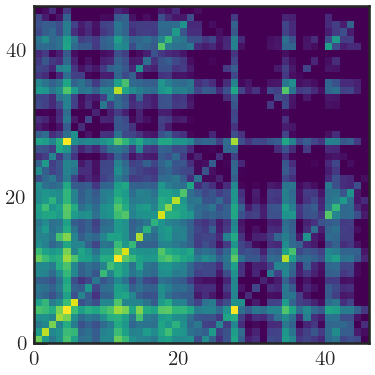

([<matplotlib.axis.YTick at 0x21780f11810>,
 [Text(0, 0, '$\\mathdefault{0}$'),
  Text(0, 20, '$\\mathdefault{20}$'),
  Text(0, 40, '$\\mathdefault{40}$')])

In [124]:
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
# plt.pcolormesh(Fisher_eseem_one, norm=norm, cmap='viridis', rasterized=True)
levels = MaxNLocator(nbins=100).tick_values(np.min(Fisher_onehalf), np.max(Fisher_onehalf))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-4,vmax=1e3)
im = plt.pcolormesh(Fisher_onehalf, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12) 
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher_eseem_one.svg',dpi=150)


<IPython.core.display.Javascript object>


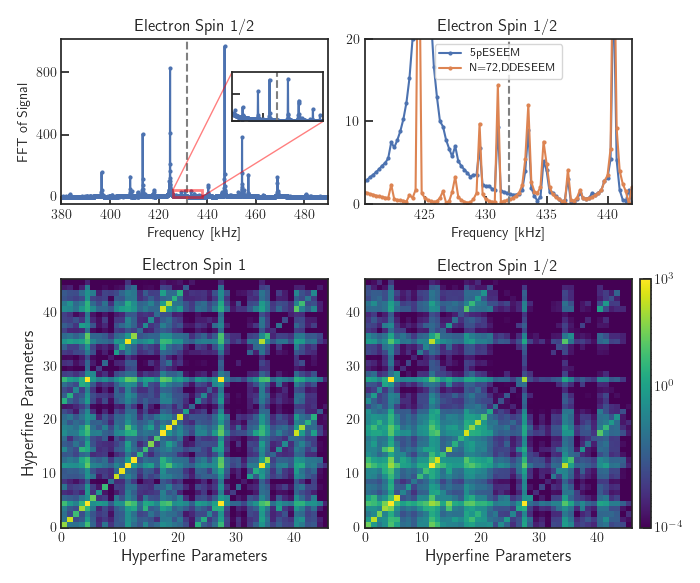

In [135]:
golden_r=1.61803398875
fig, ax = plt.subplots(2, 2, figsize=(7,7/1.2), height_ratios=[2, 3])
import string

    
ax[0,0].plot(x1, y1, '-o',markersize=2)
ax[0,0].set_xlabel("Frequency [kHz]")
ax[0,0].set_ylabel('FFT of Signal')
ax[0,0].set_xlim([380, 490])
ax[0,0].axvline(x=fL, linestyle='--',color='gray')
ax[0,0].set_yticks([0, 400, 800])
ax[0,0].set_title('Electron Spin 1/2')

axins = ax[0,0].inset_axes([0.64, 0.5, 0.34, 0.30])
axins.plot(x1, y1, '-o',markersize=2)
axins.set_xlim([426, 438])
axins.set_ylim([0, 45])
axins.axvline(x=fL, linestyle='--',color='gray')
axins.set_xticklabels([])
axins.set_yticklabels([])
ax[0,0].indicate_inset_zoom(axins, edgecolor="red", linewidth=2)
#####################################################################################################
ax[0,1].plot(x2, y21, '-o',markersize=2, label=r'5pESEEM')
ax[0,1].plot(x2, y22, '-o',markersize=2, label=r'N=72,DDESEEM')
ax[0,1].axvline(x=fL, linestyle='--',color='gray')
ax[0,1].set_title('Electron Spin 1/2')
ax[0,1].set_xlabel("Frequency [kHz]")
# ax[1].set_ylabel('FFT of Signal')
ax[0,1].set_yticks([0, 10, 20])
ax[0,1].set_xlim([420.1, 442])
ax[0,1].set_ylim([0, 20])
ax[0,1].legend(loc=0)
####################################################################################################
levels = MaxNLocator(nbins=100).tick_values(np.min(Fisher_one), np.max(Fisher_one))
cmap = plt.get_cmap('PiYG')
norm = colors.LogNorm(vmin=1e-4,vmax=1e3)
im = ax[1,0].pcolormesh(Fisher_one, norm=norm, cmap='viridis', rasterized=True)
ax[1,0].set_xlabel('Hyperfine Parameters', fontsize=12)
ax[1,0].set_ylabel('Hyperfine Parameters', fontsize =12)
ax[1,0].set_title('Electron Spin 1')
####################################################################################################
im = ax[1,1].pcolormesh(Fisher_onehalf, norm=norm, cmap='viridis', rasterized=True)
ax[1,1].set_title('Electron Spin 1/2')
ax[1,1].set_xlabel('Hyperfine Parameters', fontsize=12)
cax = ax[1,1].inset_axes([ax[1,1].get_position().x1+0.13, 0, 0.04, 1])
cb = fig.colorbar(im, cax=cax)
cb.set_ticks([1e-4, 1e0, 1e3]) # set ticks of your format  
# for n, axs in enumerate(ax.flat):
#     axs.text(-0.1, 1.1, string.ascii_lowercase[n]+'.', transform=axs.transAxes, size=15, weight='bold')
    
fig.tight_layout()
fig.savefig('eseem_compare2.pdf',dpi=300)